In [1]:
import pandas as pd
import numpy as np
import argparse
import time
import pickle as pkl

from itertools import product
from functools import reduce

import seaborn as sns
sns.set(style="whitegrid", font_scale = 2.5)
sns.set_context(rc={"lines.markersize": 17, "lines.linewidth": 2})

import matplotlib.pyplot as plt

In [2]:
parser = argparse.ArgumentParser(description='Compute features from sparse dataset')

parser.add_argument('--temporal',  type=int,
                    help='Value to bin the temporal information: 0 (remove temporal information), 1 (no binning), 10 (binning to decades), 20 (binning each 20 years) or 50 (binning each 50 years)')

parser.add_argument('--cutoff', type=int, default=50,
                    help='Cut-off frequency for each compound per time period : none (0), 20, 50 and 100')

parser.add_argument('--contextual', action='store_true',
                    help='Is the model contextual')
parser.add_argument('--inputdir',type=str,
                    help='Provide directory where features are located')
parser.add_argument('--outputdir',type=str,
                    help='Where should the output be stored?')

parser.add_argument('--tag', action='store_true',
                    help='Should the POS tag be kept?')

args = parser.parse_args('--inputdir ../datasets/compound_aware/ --contextual --outputdir ../datasets/compound_aware/'.split())

In [3]:
test_df=pd.read_csv('/data/dharp/compounds/Compounding/data/all_compounds.txt',sep='\t')


copy_df=test_df.copy()
copy_df.modifier=copy_df.modifier.str.split('_').str[0]
copy_df['head']=copy_df['head'].str.split('_').str[0]

if args.tag:
    copy_df_1=copy_df.copy()
    copy_df_1.modifier=copy_df_1.modifier+'_NOUN'
    copy_df_1['head']=copy_df_1['head']+'_NOUN'

    copy_df_2=copy_df.copy()
    copy_df_2.modifier=copy_df_2.modifier+'_PROPN'
    copy_df_2['head']=copy_df_2['head']+'_NOUN'

    copy_df_3=copy_df.copy()
    copy_df_3.modifier=copy_df_3.modifier+'_NOUN'
    copy_df_3['head']=copy_df_3['head']+'_PROPN'

    copy_df_4=copy_df.copy()
    copy_df_4.modifier=copy_df_4.modifier+'_PROPN'
    copy_df_4['head']=copy_df_4['head']+'_PROPN'


    compound_df=pd.concat([copy_df_1,copy_df_2,copy_df_3,copy_df_4],ignore_index=True)

else:
    compound_df=copy_df.copy()

In [4]:
def process_time_compound(df):

    print(f'Temporal information is stored with intervals {temporal}')

    if temporal==0:
        df['time']=0
    else:
        df['time']=df['year'] - df['year']%temporal
    
    df=df.groupby(['modifier','head','time','context'],observed=True)['count'].sum().to_frame()
    df.reset_index(inplace=True)
    return df
        
def process_cutoff_compound(df):

    df=df.loc[df.groupby(['modifier','head','time'],observed=True)['count'].transform('sum').gt(cutoff)]
    df=df.groupby(['modifier','head','time','context'],observed=True)['count'].sum().to_frame()
    
    df.reset_index(inplace=True)
    return df


def process_modifier(df):
            
    if temporal==0:
        df['time']=0
    else:
        df['time']=df['year'] - df['year']%temporal
        
    df=df.groupby(['modifier','time','context'],observed=True)['count'].sum().to_frame()

    df.reset_index(inplace=True)
    
    return df


def process_head(df):
    
    if temporal==0:
        df['time']=0
    else:
        df['time']=df['year'] - df['year']%temporal
        
    df=df.groupby(['head','time','context'],observed=True)['count'].sum().to_frame()
    
    df.reset_index(inplace=True)
    
    return df

In [5]:
def calculate_compound_features():
                  
    print('Calculating productivity features')

    compound_counts=all_comps.groupby(['time']).size().to_frame()
    compound_counts.columns=['N']

    mod_prod=all_comps.groupby(['modifier','time'],observed=True).size().to_frame()
    mod_prod.columns=['mod_prod']
    mod_prod=pd.merge(mod_prod.reset_index(),compound_counts.reset_index(),on=['time'],how='left')
    mod_prod['mod_family_size']=1+np.log2(mod_prod.N/(mod_prod.mod_prod+1))

    not_found_mod_prod=not_found_modifiers_df.copy()
    not_found_mod_prod['mod_prod']=0
    not_found_mod_prod=pd.merge(not_found_mod_prod,compound_counts.reset_index(),on=['time'],how='left')
    not_found_mod_prod['mod_family_size']=1+np.log2(not_found_mod_prod.N/(not_found_mod_prod.mod_prod+1))

    head_prod=all_comps.groupby(['head','time'],observed=True).size().to_frame()
    head_prod.columns=['head_prod']
    head_prod=pd.merge(head_prod.reset_index(),compound_counts.reset_index(),on=['time'],how='left')
    head_prod['head_family_size']=1+np.log2(head_prod.N/(head_prod.head_prod+1))

    not_found_head_prod=not_found_heads_df.copy()
    not_found_head_prod['head_prod']=0
    not_found_head_prod=pd.merge(not_found_head_prod,compound_counts.reset_index(),on=['time'],how='left')
    not_found_head_prod['head_family_size']=1+np.log2(not_found_head_prod.N/(not_found_head_prod.head_prod+1))

    mod_prod=pd.concat([mod_prod,not_found_mod_prod],ignore_index=True)
    head_prod=pd.concat([head_prod,not_found_head_prod],ignore_index=True)

    prod1=pd.merge(mod_prod.drop('N',axis=1),all_comps,on=['modifier','time'],how='right')
    productivity=pd.merge(head_prod,prod1,on=['head','time'],how='right')
    productivity['comp_prod']=1
    productivity['comp_family_size']=1+np.log2(productivity.N/(productivity.comp_prod+1))

    not_found_prod1=pd.merge(not_found_compounds_df,mod_prod.drop('N',axis=1),how='left',on=['modifier','time'])
    not_found_productivity=pd.merge(not_found_prod1,head_prod,how='left',on=['head','time'])
    not_found_productivity['comp_prod']=0
    not_found_productivity['comp_family_size']=1+np.log2(not_found_productivity.N/(not_found_productivity.comp_prod+1))


    productivity=pd.concat([productivity,not_found_productivity],ignore_index=True)
    productivity.set_index(['modifier','head','time'],inplace=True)

    productivity['const_prod']=productivity.mod_family_size*productivity.head_family_size
    productivity.drop('N',axis=1,inplace=True)

    print('Calculating information theory features')

    compound_time_counts=compounds.groupby('time').sum().sum(axis=1).to_frame()
    compound_time_counts.columns=['N']
    compound_time_counts.N=compound_time_counts.N.astype('float64')

    XY=compounds.groupby(['modifier','head','time'],observed=True).sum().sum(axis=1).to_frame()
    X_star=compounds.groupby(['modifier','time'],observed=True).sum().sum(axis=1).to_frame()
    Y_star=compounds.groupby(['head','time'],observed=True).sum().sum(axis=1).to_frame()

    XY.columns=['a']
    XY.a=XY.a.astype('float64')

    X_star.columns=['x_star']
    X_star.x_star=X_star.x_star.astype('float64')

    Y_star.columns=['star_y']
    Y_star.star_y=Y_star.star_y.astype('float64')

    merge1=pd.merge(XY.reset_index(),X_star.reset_index(),on=['modifier','time'])

    information_feat=pd.merge(merge1,Y_star.reset_index(),on=['head','time'])    

    information_feat['b']=information_feat['x_star']-information_feat['a']
    information_feat['c']=information_feat['star_y']-information_feat['a']


    information_feat=pd.merge(information_feat,compound_time_counts.reset_index(),on=['time'])

    information_feat['d']=information_feat['N']-(information_feat['a']+information_feat['b']+information_feat['c'])
    information_feat['x_bar_star']=information_feat['N']-information_feat['x_star']
    information_feat['star_y_bar']=information_feat['N']-information_feat['star_y']

    information_feat['log_ratio']=2*(\
    information_feat['a']*np.log2((information_feat['a']*information_feat['N']+1)/(information_feat['x_star']*information_feat['star_y']+1))+\
    information_feat['b']*np.log2((information_feat['b']*information_feat['N']+1)/(information_feat['x_star']*information_feat['star_y_bar']+1))+\
    information_feat['c']*np.log2((information_feat['c']*information_feat['N']+1)/(information_feat['x_bar_star']*information_feat['star_y']+1))+\
    information_feat['d']*np.log2((information_feat['d']*information_feat['N']+1)/(information_feat['x_bar_star']*information_feat['star_y_bar']+1)))
    information_feat['ppmi']=np.log2((information_feat['a']*information_feat['N']+1)/(information_feat['x_star']*information_feat['star_y']+1))
    information_feat['local_mi']=information_feat['a']*information_feat['ppmi']
    information_feat.loc[information_feat.ppmi<=0,'ppmi']=0
    information_feat.drop(['a','x_star','star_y','b','c','d','N','d','x_bar_star','star_y_bar'],axis=1,inplace=True)

    not_found_information_feat=not_found_compounds_df.copy()
    not_found_information_feat['log_ratio']=0
    not_found_information_feat['ppmi']=0
    not_found_information_feat['local_mi']=0


    information_feat=pd.concat([information_feat,not_found_information_feat],ignore_index=True)

    information_feat.set_index(['modifier','head','time'],inplace=True)
            
    print('Frequency features')
            
            
    not_found_X_star=not_found_modifiers_df.groupby(['modifier','time'],observed=True).sum().sum(axis=1).to_frame()
    not_found_X_star.columns=['x_star']

    not_found_Y_star=not_found_heads_df.groupby(['head','time'],observed=True).sum().sum(axis=1).to_frame()
    not_found_Y_star.columns=['star_y']

    X_star=pd.concat([X_star,not_found_X_star])
    Y_star=pd.concat([Y_star,not_found_Y_star])
            
            
    frequency_feat=pd.merge(XY.reset_index(),X_star.reset_index(),on=['modifier','time'],how='left')
    frequency_feat=frequency_feat.merge(Y_star.reset_index(),on=['head','time'],how='left')
    frequency_feat=frequency_feat.merge(compound_time_counts.reset_index(),on='time')
    frequency_feat.set_index(['modifier','head','time'],inplace=True)
    frequency_feat.columns=['comp_freq','mod_freq','head_freq','N']
    frequency_feat['comp_tf']=np.log2(1+frequency_feat.comp_freq)
    frequency_feat['log_comp_freq']=np.log2(frequency_feat.N/(frequency_feat.comp_freq+1))

    frequency_feat['mod_tf']=np.log2(1+frequency_feat.mod_freq)
    frequency_feat['log_mod_freq']=np.log2(frequency_feat.N/(frequency_feat.mod_freq+1))

    frequency_feat['head_tf']=np.log2(1+frequency_feat.head_freq)
    frequency_feat['log_head_freq']=np.log2(frequency_feat.N/(frequency_feat.head_freq+1))

    not_found_frequency_feat=not_found_compounds_df.groupby(['modifier','head','time'],observed=True).sum().sum(axis=1).to_frame()
    not_found_frequency_feat=pd.merge(not_found_frequency_feat.reset_index(),X_star.reset_index(),on=['modifier','time'])
    not_found_frequency_feat=pd.merge(not_found_frequency_feat,Y_star.reset_index(),on=['head','time'])
    not_found_frequency_feat=not_found_frequency_feat.merge(compound_time_counts.reset_index(),on='time')
    not_found_frequency_feat.set_index(['modifier','head','time'],inplace=True)
    not_found_frequency_feat.columns=['comp_freq','mod_freq','head_freq','N']


    not_found_frequency_feat['comp_tf']=np.log2(1+not_found_frequency_feat.comp_freq)
    not_found_frequency_feat['log_comp_freq']=np.log2(not_found_frequency_feat.N/(not_found_frequency_feat.comp_freq+1))

    not_found_frequency_feat['mod_tf']=np.log2(1+not_found_frequency_feat.mod_freq)
    not_found_frequency_feat['log_mod_freq']=np.log2(not_found_frequency_feat.N/(not_found_frequency_feat.mod_freq+1))

    not_found_frequency_feat['head_tf']=np.log2(1+not_found_frequency_feat.head_freq)
    not_found_frequency_feat['log_head_freq']=np.log2(not_found_frequency_feat.N/(not_found_frequency_feat.head_freq+1))


    frequency_feat=pd.concat([frequency_feat,not_found_frequency_feat])
    frequency_feat.drop('N',axis=1,inplace=True)
    
    return productivity,information_feat,frequency_feat

    
    
def calculate_cosine_features():
    
    print('Calculating denominator values')

    compound_denom=compounds.copy()
    compound_denom['count']=compound_denom['count']**2
    compound_denom=compound_denom.groupby(['modifier','head','time'],observed=True)['count'].sum().to_frame()
    compound_denom['count']=np.sqrt(compound_denom['count'])
    compound_denom.columns=['compound_denom']

    modifier_denom=modifiers.copy()
    modifier_denom['count']=modifier_denom['count']**2
    modifier_denom=modifier_denom.groupby(['modifier','time'],observed=True)['count'].sum().to_frame()
    modifier_denom['count']=np.sqrt(modifier_denom['count'])
    modifier_denom.columns=['modifier_denom']

    head_denom=heads.copy()
    head_denom['count']=head_denom['count']**2
    head_denom=head_denom.groupby(['head','time'],observed=True)['count'].sum().to_frame()
    head_denom['count']=np.sqrt(head_denom['count'])
    head_denom.columns=['head_denom']

    mod_cols=modifiers.columns.tolist()
    mod_cols[-1]="mod_count"
    modifiers.columns=mod_cols

    head_cols=heads.columns.tolist()
    head_cols[-1]="head_count"
    heads.columns=head_cols

            #compounds.drop(['comp_count'],axis=1,inplace=True)
    comp_cols=compounds.columns.tolist()
    comp_cols[-1]="comp_count"
    compounds.columns=comp_cols

    print('Calculating cosine features')

    compound_modifier_sim=pd.merge(compounds,modifiers,on=["modifier","context",'time'])
    compound_modifier_sim['numerator']=compound_modifier_sim['comp_count']*compound_modifier_sim['mod_count']
    compound_modifier_sim=compound_modifier_sim.groupby(['modifier','head','time'],observed=True)['numerator'].sum().to_frame()
    compound_modifier_sim=pd.merge(compound_modifier_sim.reset_index(),compound_denom.reset_index(),on=["modifier","head",'time'])
    compound_modifier_sim=pd.merge(compound_modifier_sim,modifier_denom.reset_index(),on=['modifier','time'])
    compound_modifier_sim['sim_with_modifier']=compound_modifier_sim['numerator']/(compound_modifier_sim['compound_denom']*compound_modifier_sim['modifier_denom'])
    compound_modifier_sim.set_index(['modifier','head','time'],inplace=True)
    compound_modifier_sim.drop(['numerator','compound_denom'],axis=1,inplace=True)

    compound_head_sim=pd.merge(compounds,heads,on=["head","context",'time'])
    compound_head_sim['numerator']=compound_head_sim['comp_count']*compound_head_sim['head_count']
    compound_head_sim=compound_head_sim.groupby(['modifier','head','time'],observed=True)['numerator'].sum().to_frame()
    compound_head_sim=pd.merge(compound_head_sim.reset_index(),compound_denom.reset_index(),on=["modifier","head",'time'])
    compound_head_sim=pd.merge(compound_head_sim,head_denom.reset_index(),on=['head','time'])
    compound_head_sim['sim_with_head']=compound_head_sim['numerator']/(compound_head_sim['compound_denom']*compound_head_sim['head_denom'])
    compound_head_sim.set_index(['modifier','head','time'],inplace=True)
    compound_head_sim.drop(['numerator','compound_denom'],axis=1,inplace=True)

    constituent_sim=pd.merge(heads,compounds,on=["head","context","time"])
    #constituent_sim.drop('comp_count',axis=1,inplace=True)
    constituent_sim=pd.merge(constituent_sim,modifiers,on=["modifier","context","time"])
    constituent_sim['numerator']=constituent_sim['head_count']*constituent_sim['mod_count']
    constituent_sim=constituent_sim.groupby(['modifier','head','time'],observed=True)['numerator'].sum().to_frame()
    constituent_sim=pd.merge(constituent_sim.reset_index(),head_denom.reset_index(),on=["head","time"])
    constituent_sim=pd.merge(constituent_sim,modifier_denom.reset_index(),on=["modifier","time"])
    constituent_sim['sim_bw_constituents']=constituent_sim['numerator']/(constituent_sim['head_denom']*constituent_sim['modifier_denom'])
    constituent_sim.set_index(['modifier','head','time'],inplace=True)
    constituent_sim.drop(['numerator','modifier_denom','head_denom'],axis=1,inplace=True)
    
    return compound_modifier_sim,compound_head_sim,constituent_sim



def feature_extractor():
    
    
    productivity,information_feat,frequency_feat=calculate_compound_features()
            

    compound_modifier_sim,compound_head_sim,constituent_sim=calculate_cosine_features()

    print('Storing all features together')

    dfs = [frequency_feat,constituent_sim, compound_head_sim.sim_with_head, compound_modifier_sim.sim_with_modifier, information_feat,productivity]
    compounds_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True,how='outer'), dfs)

    compounds_final=pd.pivot_table(compounds_final.reset_index(), index=['modifier','head'], columns=['time'])
    compounds_final_1=compounds_final.columns.get_level_values(0)
    compounds_final_2=compounds_final.columns.get_level_values(1)

    cur_year=0
    new_columns=[]
    for year in compounds_final_2:
        new_columns.append(compounds_final_1[cur_year]+":"+str(year))
        cur_year+=1

    compounds_final.columns=new_columns
    return compounds_final 

In [6]:
cutoff_list=[0,10,20,50,100,500,1000]
temporal_list=[0,10,20,50,100]

In [ ]:
    print("CompoundAware Model")
    print("Loading the constituent and compound datasets")

    complete_compounds=pd.read_pickle(args.inputdir+"/compounds.pkl")
    
    complete_modifiers=pd.read_pickle(args.inputdir+"/modifiers.pkl")

    complete_heads=pd.read_pickle(args.inputdir+"/heads.pkl")
    
    
    if not args.tag:
        print('Removing tags')
        complete_compounds['head']=complete_compounds['head'].str.replace('_NOUN|_PROPN','',regex=True)
        complete_compounds.modifier=complete_compounds.modifier.str.replace('_NOUN|_PROPN','',regex=True)

        complete_modifiers.modifier=complete_modifiers.modifier.str.replace('_NOUN|_PROPN','',regex=True)

        complete_heads['head']=complete_heads['head'].str.replace('_NOUN|_PROPN','',regex=True)

CompoundAware Model
Loading the constituent and compound datasets


In [ ]:
        temporal=10
        print(f'Time span:  {temporal}')
        
        temporal_compounds=process_time_compound(complete_compounds)

        modifiers=process_modifier(complete_modifiers)
        print('Done reading modifiers')

        heads=process_head(complete_heads)
        print('Done reading heads')

In [ ]:
            cutoff=0
            print(f'Cutoff: {cutoff}')
            print(f'Time span:  {temporal}')
            temp_cutoff_str=str(temporal)+'_'+str(cutoff)
            
            if cutoff==0:
                compounds=temporal_compounds.copy()
                
            else:

                compounds=process_cutoff_compound(temporal_compounds)

            print('Done reading compounds')
            
            
            timespan_list_df=pd.DataFrame(compounds.time.unique())
            timespan_list_df.columns=['time']

            compound_list_df=compound_df[['modifier','head']].copy()
            compound_list_df=compound_list_df.merge(timespan_list_df,how='cross')

            modifier_list_df=compound_df[['modifier']].drop_duplicates()
            modifier_list_df=modifier_list_df.merge(timespan_list_df,how='cross')

            head_list_df=compound_df[['head']].drop_duplicates()
            head_list_df=head_list_df.merge(timespan_list_df,how='cross')
            
            all_comps=compounds[['modifier','head','time']].copy()
            all_comps.drop_duplicates(inplace=True)
           
            all_mods=compounds[['modifier','time']].copy()
            all_mods.drop_duplicates(inplace=True)
            
            all_heads=compounds[['head','time']].copy()
            all_heads.drop_duplicates(inplace=True)
            
            not_found_compounds_df=compound_list_df.merge(all_comps, on=['modifier','head','time'], how='outer', suffixes=['', '_'], indicator=True)
            not_found_compounds_df=not_found_compounds_df.loc[not_found_compounds_df['_merge']=='left_only']
            not_found_compounds_df.drop('_merge',axis=1,inplace=True)
            
            
            not_found_modifiers_df=modifier_list_df.merge(all_mods, on=['modifier','time'], how='outer', suffixes=['', '_'], indicator=True)
            not_found_modifiers_df=not_found_modifiers_df.loc[not_found_modifiers_df['_merge']=='left_only']
            not_found_modifiers_df.drop('_merge',axis=1,inplace=True)
            
            not_found_heads_df=head_list_df.merge(all_heads, on=['head','time'], how='outer', suffixes=['', '_'], indicator=True)
            not_found_heads_df=not_found_heads_df.loc[not_found_heads_df['_merge']=='left_only']
            not_found_heads_df.drop('_merge',axis=1,inplace=True)

In [12]:
compounds_final=feature_extractor()



Calculating productivity features
Calculating information theory features
Frequency features
Calculating denominator values
Calculating cosine features
Storing all features together


In [13]:


            plotdir = "/data/dharp/compounds/Compounding/compositionality_over_time/Plots/google/"
            if args.contextual:
                comp_str='CompoundAware'
            else:
                comp_str='CompoundAgnostic'

            if args.tag:
                tag_str='Tagged'
            else:
                tag_str='UnTagged'

            print(f'Cutoff: {cutoff}')
            print(f'Time span:  {temporal}')
            temp_cutoff_str=str(temporal)+'_'+str(cutoff)

Cutoff: 0
Time span:  10


In [14]:
compounds_final.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8898540 entries, ('a', 'a') to ('zzzwgas', 'modified')
Columns: 484 entries, comp_family_size:1800 to sim_with_modifier:2010
dtypes: float64(484)
memory usage: 32.2+ GB


In [14]:
                compounds_complete_index=compounds_final.index
                print(len(compounds_complete_index))

                compound_pivot=pd.pivot_table(constituent_sim,columns='time',index=['modifier','head'],values='sim_bw_constituents')
                compounds_decades_all_index=compound_pivot.dropna().index
                print(len(compounds_decades_all_index))

                columns_names_1900_end=compound_pivot.columns[compound_pivot.columns>=1900]
                compounds_1900_end_index=compound_pivot.loc[:,columns_names_1900_end].dropna().index
                print(len(compounds_1900_end_index))

                columns_names_1950_end=compound_pivot.columns[compound_pivot.columns>=1950]
                compounds_1950_end_index=compound_pivot.loc[:,columns_names_1950_end].dropna().index
                print(len(compounds_1950_end_index))

                columns_names_2000_end=compound_pivot.columns[compound_pivot.columns>=2000]
                compounds_2000_end_index=compound_pivot.loc[:,columns_names_2000_end].dropna().index
                print(len(compounds_2000_end_index))

                compound_index_lst=[compounds_complete_index,compounds_decades_all_index,compounds_1900_end_index,compounds_1950_end_index,compounds_2000_end_index]
                tags_lst=['complete','all','1900','1950','2000']

8898540
167734
1026502
2327486
5742842


In [15]:
cur_index_lst=compound_index_lst[0]
cur_tag=tags_lst[0]

In [16]:
                    print(cur_tag)
                    cur_df=compounds_final.loc[cur_index_lst]

                    cur_ratings_df=cur_df.reset_index().merge(compound_df,on=['modifier','head'])

complete
(211, 492)


In [24]:
pivot_list = list()
chunk_size = 100_000
cur_df.reset_index(inplace=True)
for i in range(0,len(cur_df),chunk_size):
    row_pivot =cur_df.iloc[i:i+chunk_size].melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
    pivot_list.append(row_pivot)

In [ ]:
plot_freq_df = pd.concat(pivot_list)
plot_freq_df[['variable','time']]=plot_freq_df['variable'].str.split(':',expand=True)

In [ ]:
                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_freq_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Frequency")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/freq_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


                    plot_freq_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
                    plot_freq_ratings_df[['variable','time']]=plot_freq_ratings_df['variable'].str.split(':',expand=True)
                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_freq_all_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Frequency")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/freq_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


In [17]:
                    print('Raw frequency features')
                    to_select_cols_1=[col for col in cur_df if col.startswith('comp_freq')]
                    to_select_cols_2=[col for col in cur_df if col.startswith('mod_freq')]
                    to_select_cols_3=[col for col in cur_df if col.startswith('head_freq')]
                    to_select_cols=to_select_cols_1+to_select_cols_2+to_select_cols_3

                    plot_freq_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
                    plot_freq_df[['variable','time']]=plot_freq_df['variable'].str.split(':',expand=True)

Raw frequency features


KeyboardInterrupt: 

Log Frequency


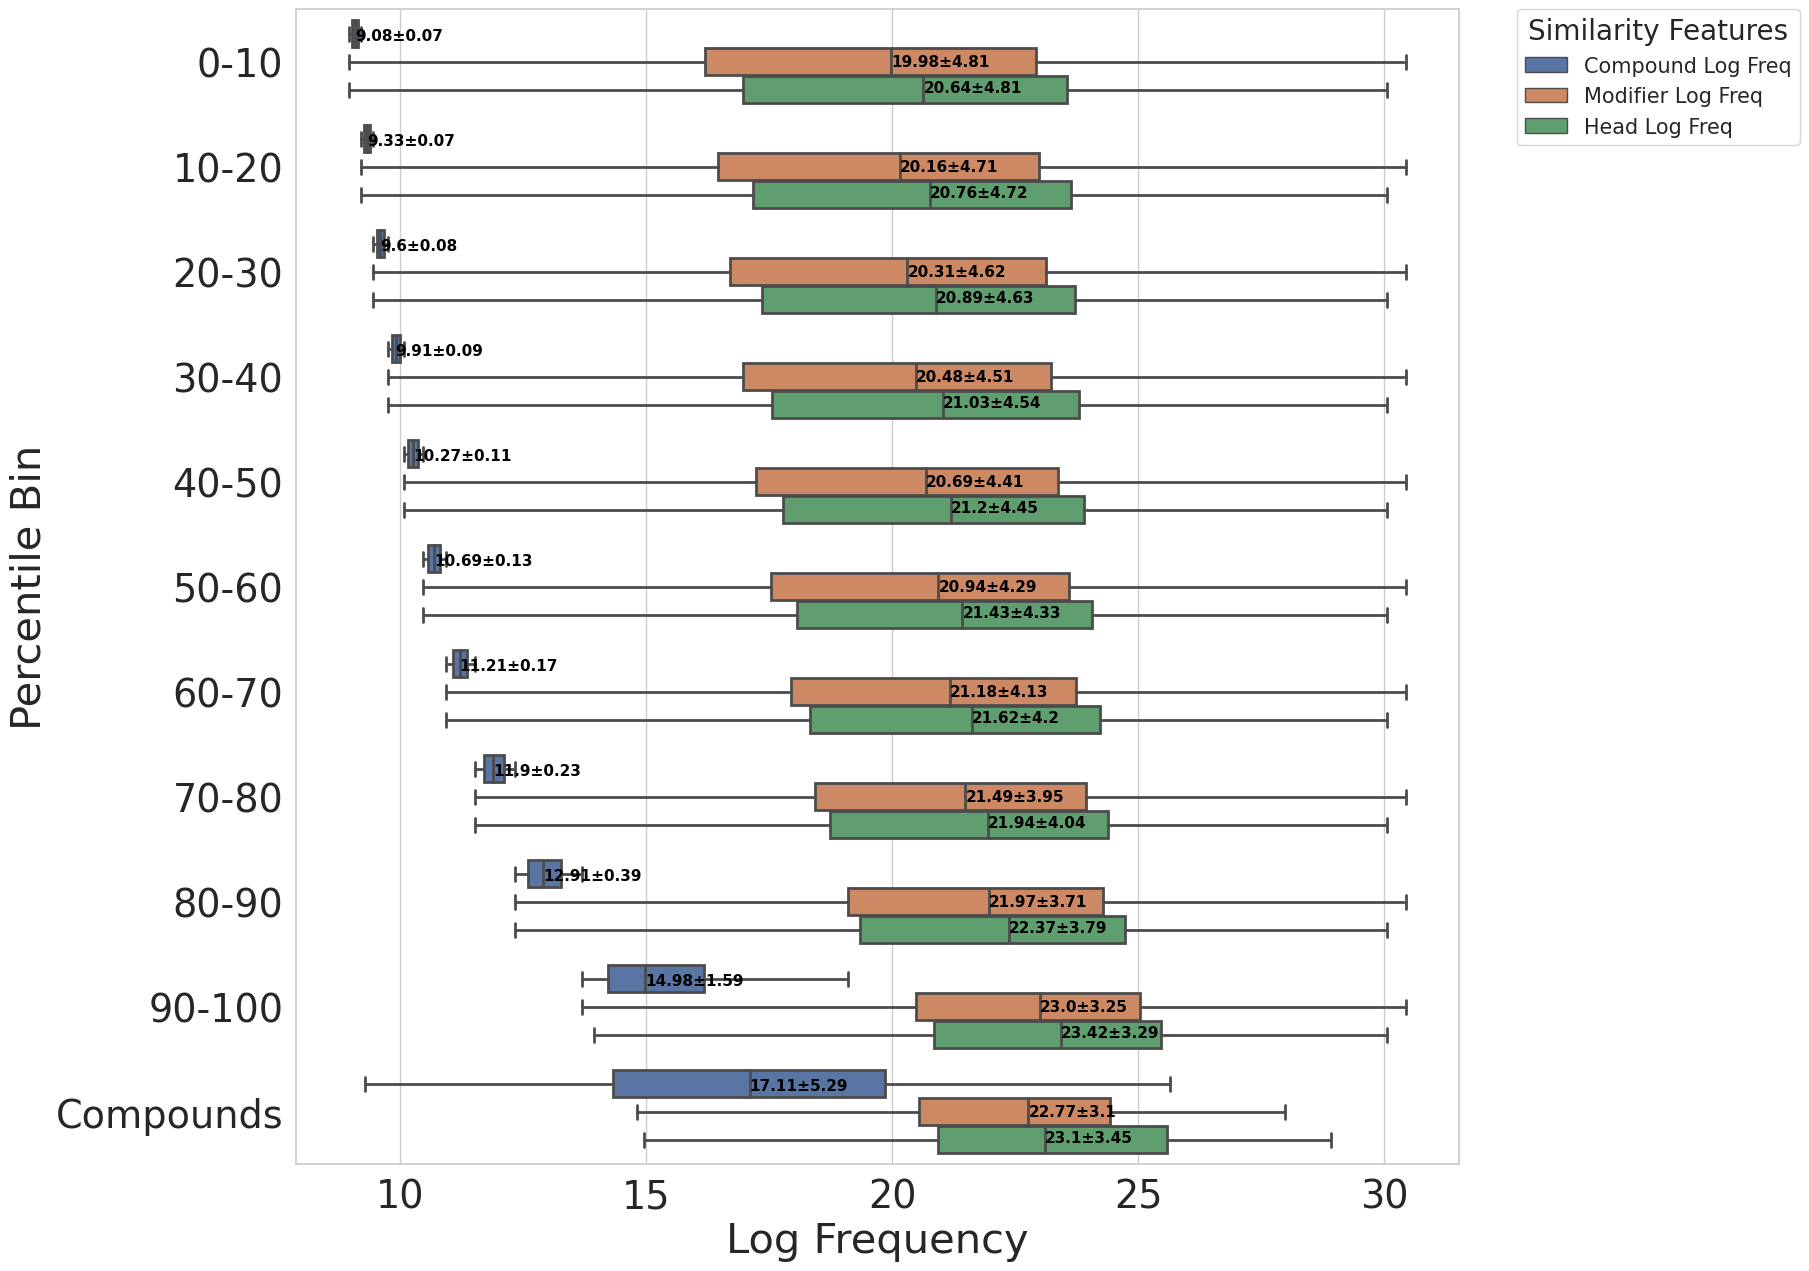

Family Size Features


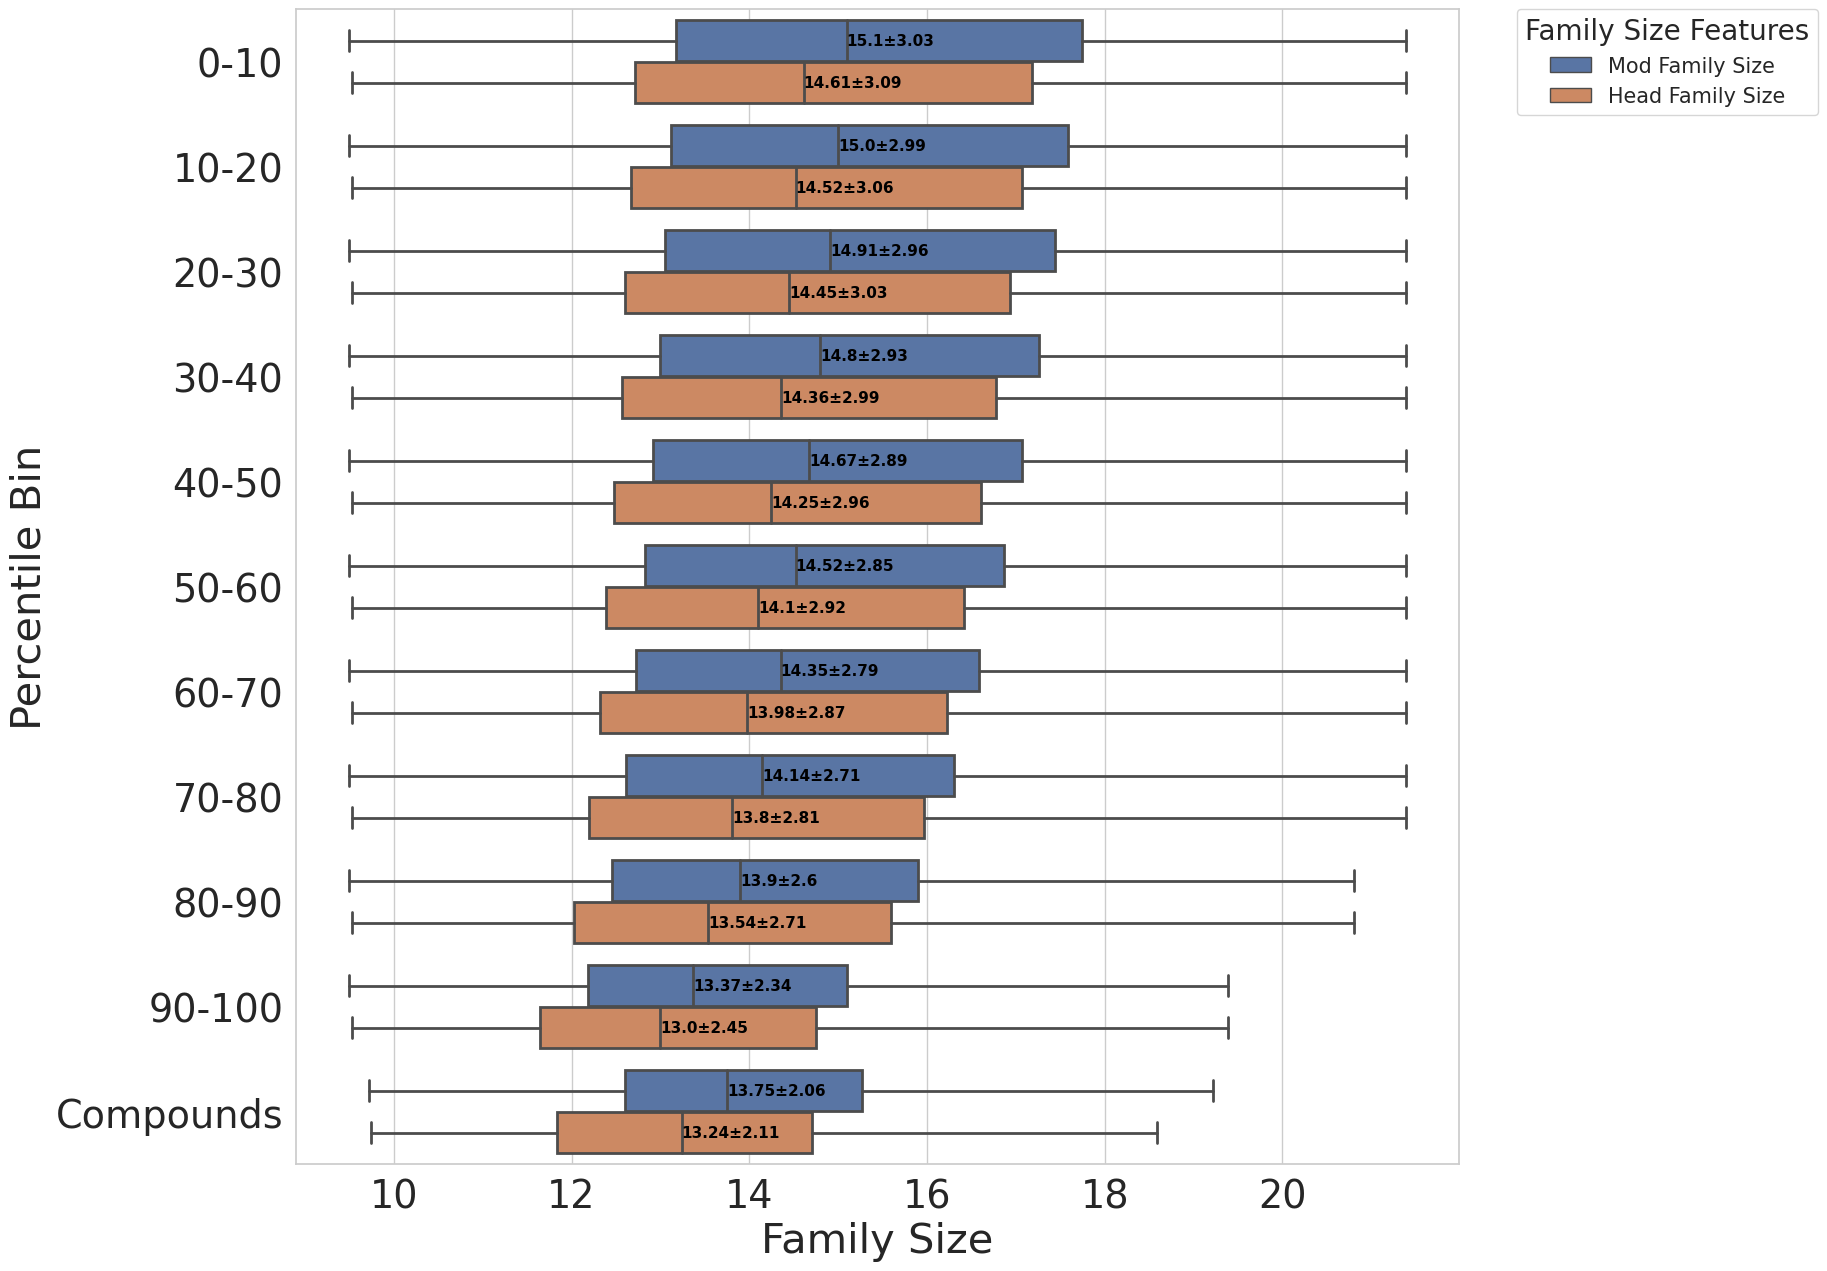

Productivity Features


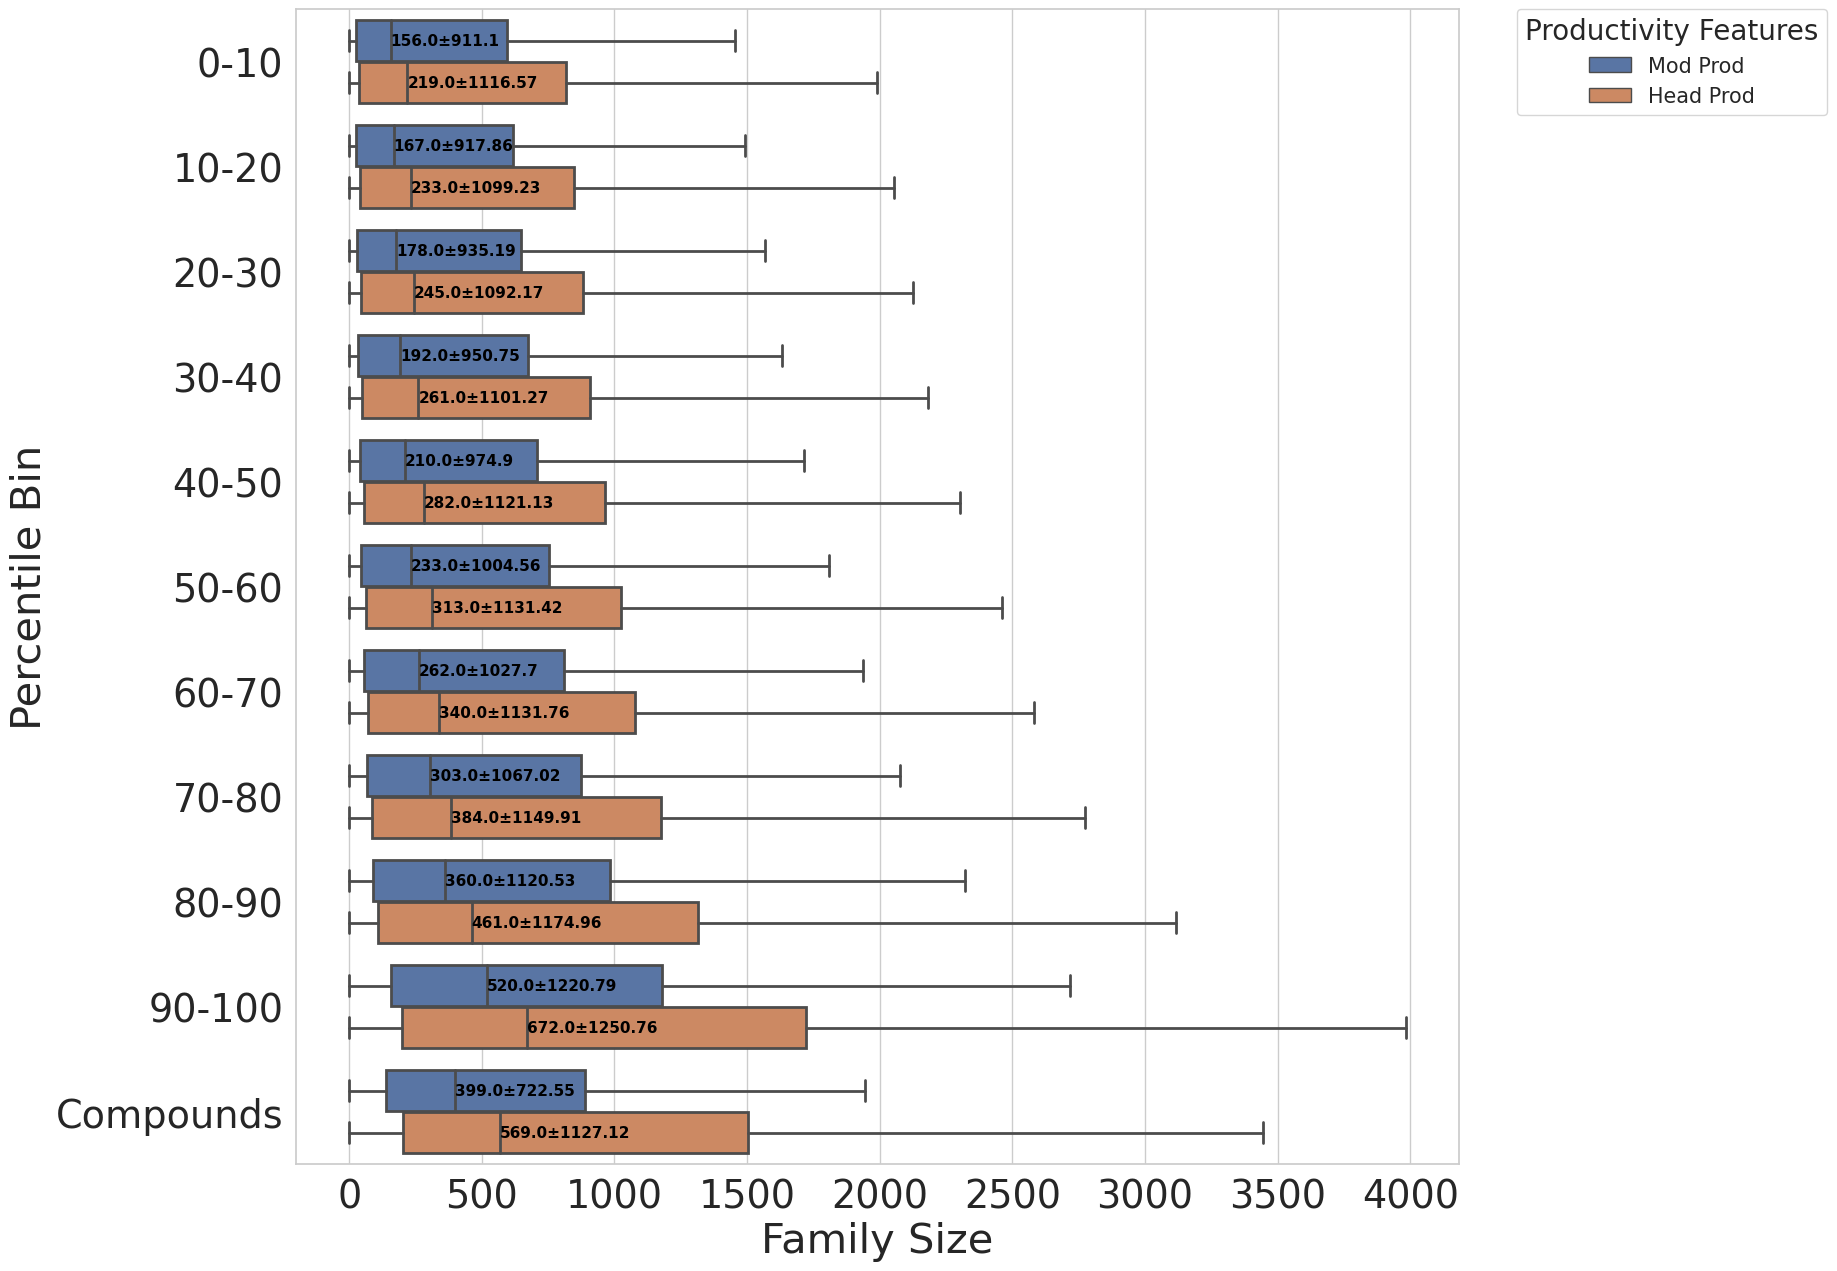

PPMI


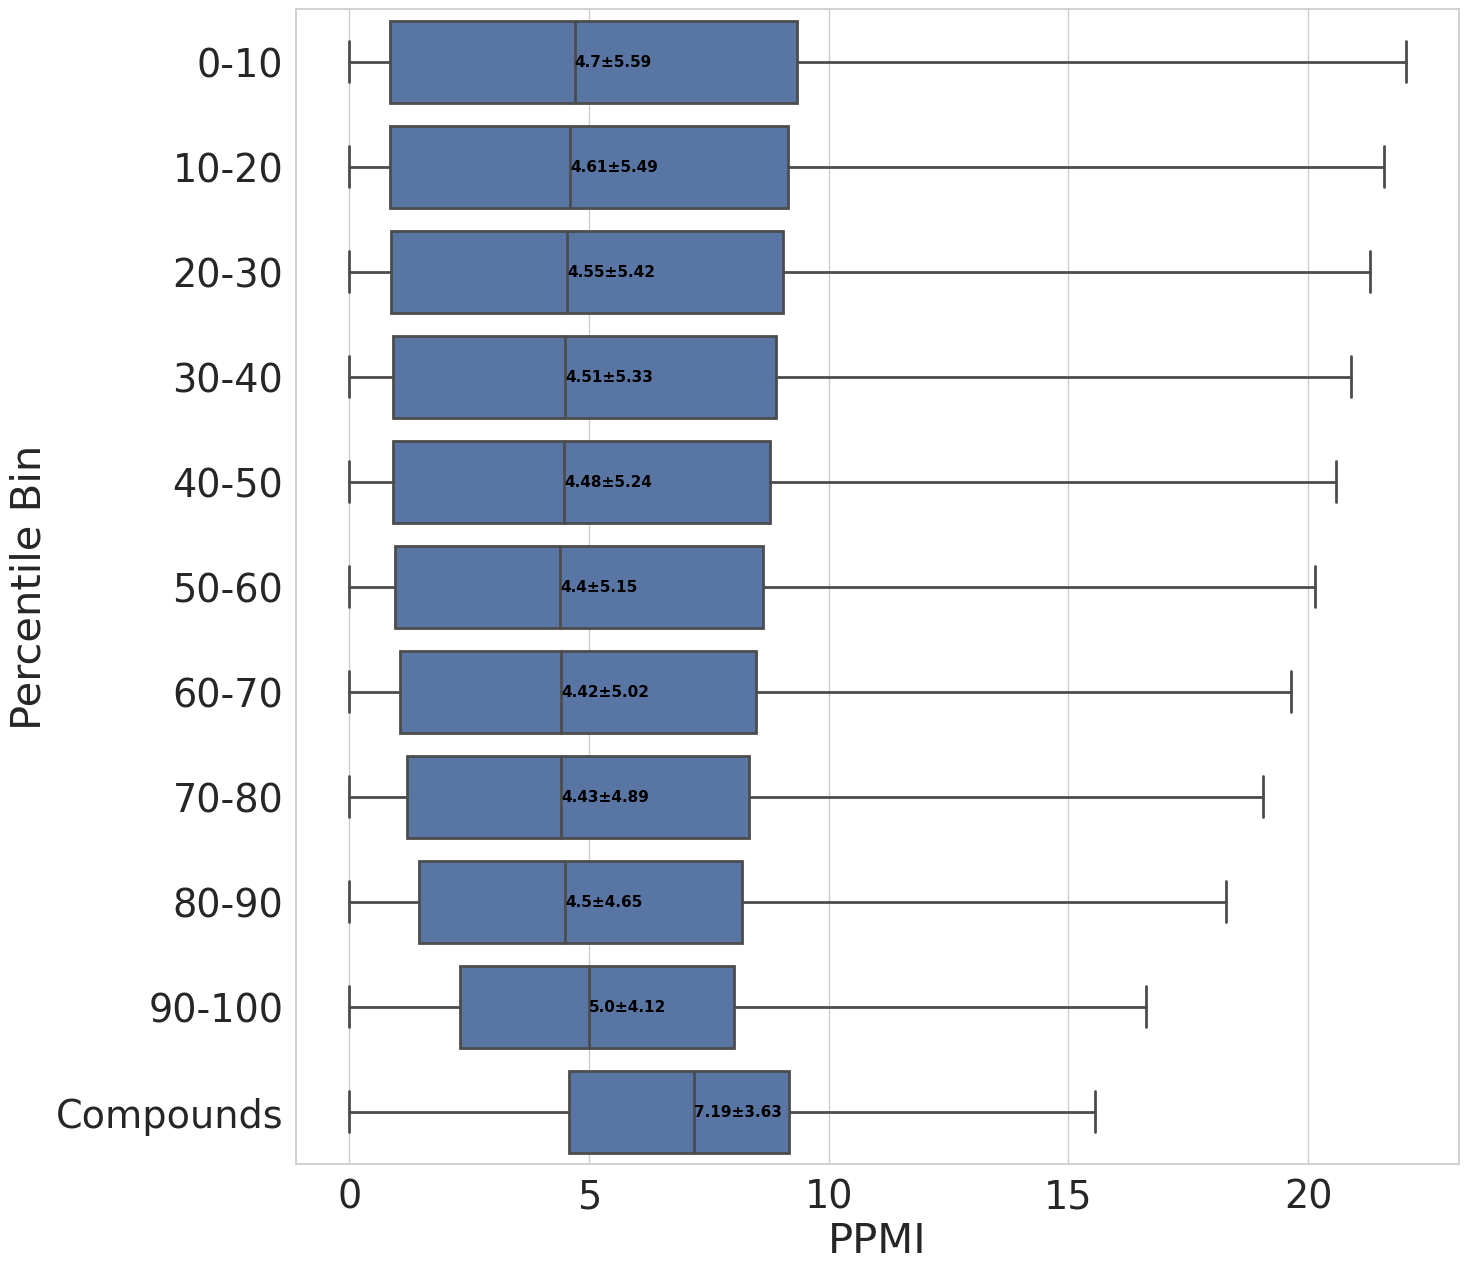

Cosine Features


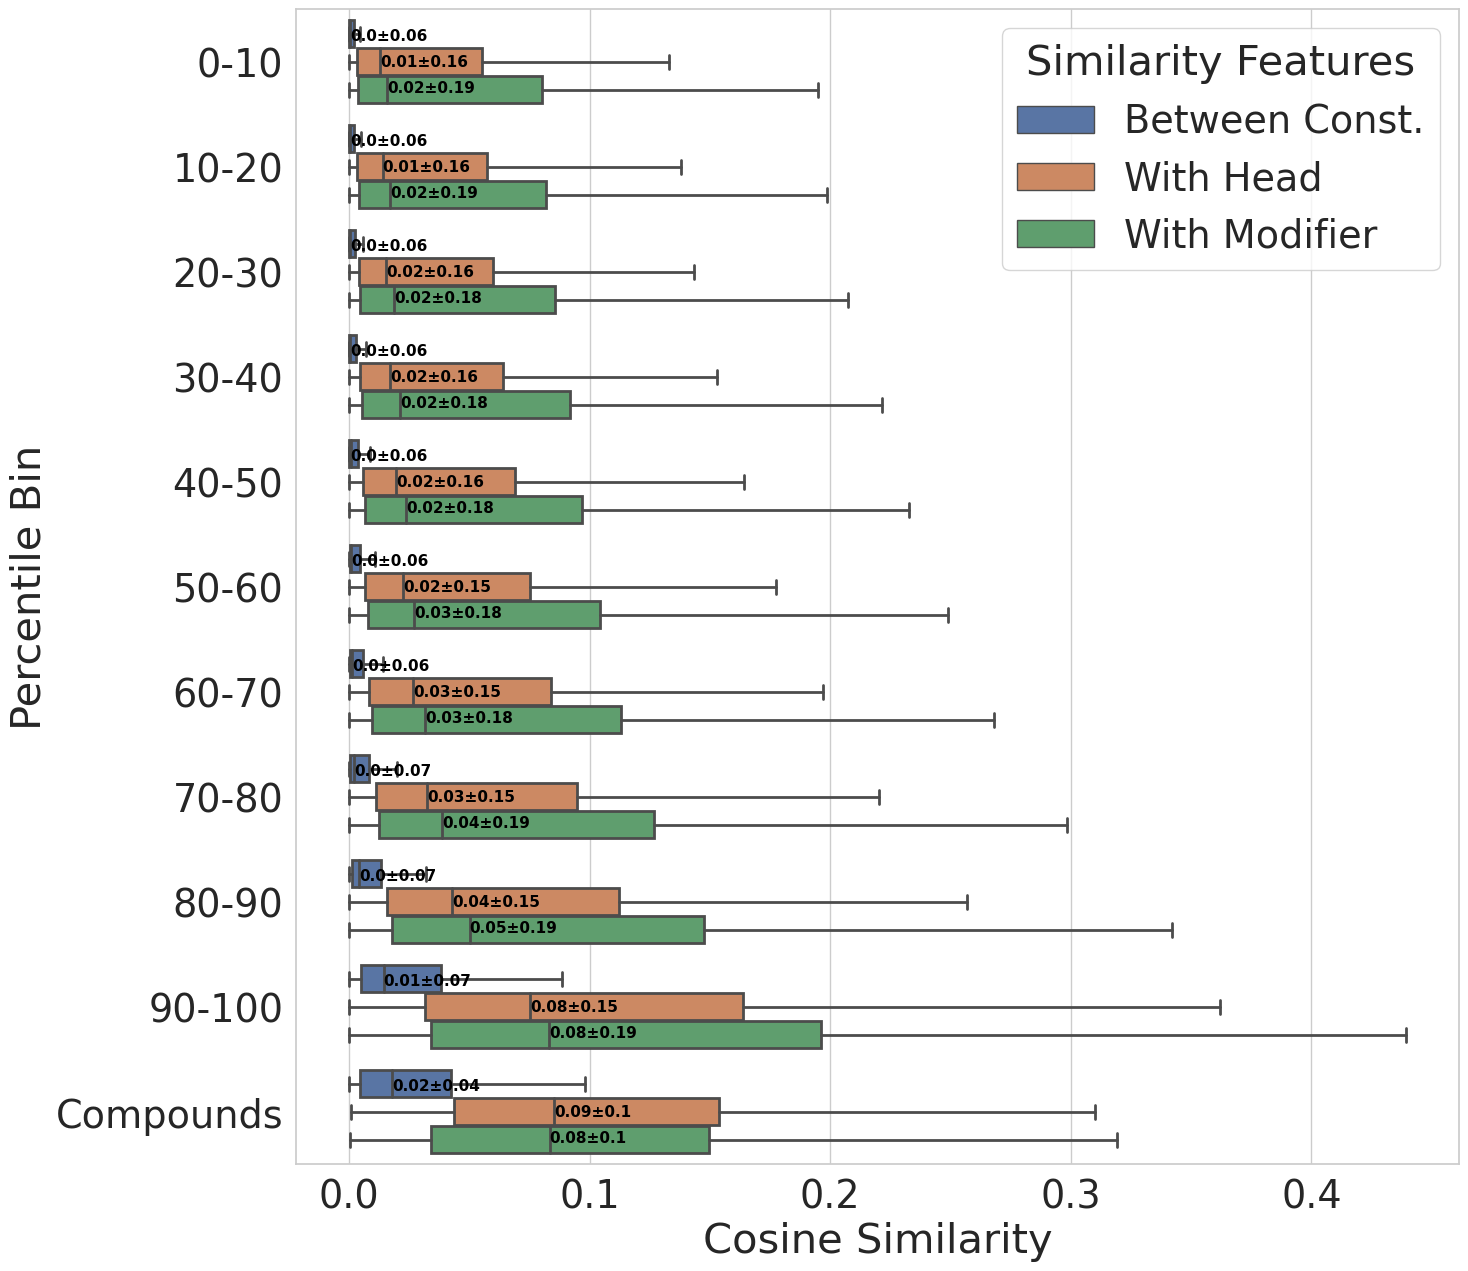

Saving the dataset


In [50]:
            
            if temporal==0:
                
                qcut_labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']

                compounds_final['comp_freq_bins']=pd.qcut(compounds_final['comp_tf:0'],q=10,labels=qcut_labels)
                compounds_final['comp_freq_bins']=compounds_final['comp_freq_bins'].astype(object)
                compounds_final.loc[pd.MultiIndex.from_frame(compound_df[['modifier','head']]),"comp_freq_bins"]="Compounds"
                compounds_final['comp_freq_bins']=compounds_final['comp_freq_bins'].astype('category')
                qcut_labels.append('Compounds')


                print('Log Frequency')

                to_select_cols=['comp_tf:0','mod_tf:0','head_tf:0']
                new_labels=['Compound Log Freq','Modifier Log Freq','Head Log Freq']
                plot_freq_df=compounds_final.reset_index().melt(id_vars=['comp_freq_bins'],value_vars=to_select_cols)
                plot_freq_df['variable'] = plot_freq_df['variable'].map(dict(zip(to_select_cols,new_labels)))

                plt.figure(figsize=(15,15))
                g=sns.boxplot(data=plot_freq_df, x="value", y="comp_freq_bins",hue='variable',order=qcut_labels,dodge=True,showfliers = False)
                g.set_xlabel("Log Frequency")
                g.set_ylabel("Percentile Bin")
                g.set_yticklabels(qcut_labels)

                med_values = plot_freq_df.groupby(['variable','comp_freq_bins'])['value'].median()
                std_dev_values= plot_freq_df.groupby(['variable','comp_freq_bins'])['value'].std()

                i=0
                for ytick in g.get_yticks():

                    g.text(med_values[new_labels[0],qcut_labels[i]],ytick-0.25,f"{round(med_values[new_labels[0],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[0],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    g.text(med_values[new_labels[1],qcut_labels[i]],ytick,f"{round(med_values[new_labels[1],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[1],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    g.text(med_values[new_labels[2],qcut_labels[i]],ytick+0.25,f"{round(med_values[new_labels[2],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[2],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    i+=1

                g.legend(title='Similarity Features', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15,title_fontsize=20)

                plt.savefig(f'{plotdir}/log_feature_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

                plt.show()

                print('Family Size Features')


                to_select_cols=['mod_family_size:0','head_family_size:0']
                new_labels=['Mod Family Size','Head Family Size']
                plot_family_size_df=compounds_final.reset_index().melt(id_vars=['comp_freq_bins'],value_vars=to_select_cols)
                plot_family_size_df['variable'] = plot_family_size_df['variable'].map(dict(zip(to_select_cols,new_labels)))

                plt.figure(figsize=(15,15))
                g=sns.boxplot(data=plot_family_size_df, x="value", y="comp_freq_bins",hue='variable',order=qcut_labels,dodge=True,showfliers = False)
                g.set_xlabel("Family Size")
                g.set_ylabel("Percentile Bin")
                g.set_yticklabels(qcut_labels)

                med_values = plot_family_size_df.groupby(['variable','comp_freq_bins'])['value'].median()
                std_dev_values= plot_family_size_df.groupby(['variable','comp_freq_bins'])['value'].std()

                i=0
                for ytick in g.get_yticks():

                    g.text(med_values[new_labels[0],qcut_labels[i]],ytick-0.2,f"{round(med_values[new_labels[0],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[0],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    g.text(med_values[new_labels[1],qcut_labels[i]],ytick+0.2,f"{round(med_values[new_labels[1],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[1],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    #g.text(med_values[new_labels[2],qcut_labels[i]],ytick+0.25,f"{round(med_values[new_labels[2],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[2],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    i+=1

                g.legend(title='Family Size Features', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15,title_fontsize=20)

                plt.savefig(f'{plotdir}/family_size_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

                plt.show()

                print('Productivity Features')

                to_select_cols=['mod_prod:0','head_prod:0']
                new_labels=['Mod Prod','Head Prod']
                plot_prod_df=compounds_final.reset_index().melt(id_vars=['comp_freq_bins'],value_vars=to_select_cols)
                plot_prod_df['variable'] = plot_prod_df['variable'].map(dict(zip(to_select_cols,new_labels)))

                plt.figure(figsize=(15,15))
                g=sns.boxplot(data=plot_prod_df, x="value", y="comp_freq_bins",hue='variable',order=qcut_labels,dodge=True,showfliers = False)
                g.set_xlabel("Family Size")
                g.set_ylabel("Percentile Bin")
                g.set_yticklabels(qcut_labels)

                med_values = plot_prod_df.groupby(['variable','comp_freq_bins'])['value'].median()
                std_dev_values= plot_prod_df.groupby(['variable','comp_freq_bins'])['value'].std()

                i=0
                for ytick in g.get_yticks():

                    g.text(med_values[new_labels[0],qcut_labels[i]],ytick-0.2,f"{round(med_values[new_labels[0],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[0],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    g.text(med_values[new_labels[1],qcut_labels[i]],ytick+0.2,f"{round(med_values[new_labels[1],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[1],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    #g.text(med_values[new_labels[2],qcut_labels[i]],ytick+0.25,f"{round(med_values[new_labels[2],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[2],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    i+=1

                g.legend(title='Productivity Features', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15,title_fontsize=20)

                plt.savefig(f'{plotdir}/prod_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

                plt.show()

                print('PPMI')

                to_select_cols=['ppmi:0']
                new_labels=['PPMI']
                plot_ppmi_df=compounds_final.reset_index().melt(id_vars=['comp_freq_bins'],value_vars=to_select_cols)
                plot_ppmi_df['variable'] = plot_ppmi_df['variable'].map(dict(zip(to_select_cols,new_labels)))

                plt.figure(figsize=(15,15))
                g=sns.boxplot(data=plot_ppmi_df, x="value", y="comp_freq_bins",hue='variable',order=qcut_labels,dodge=True,showfliers = False)
                g.set_xlabel("PPMI")
                g.set_ylabel("Percentile Bin")
                g.set_yticklabels(qcut_labels)

                med_values = plot_ppmi_df.groupby(['variable','comp_freq_bins'])['value'].median()
                std_dev_values= plot_ppmi_df.groupby(['variable','comp_freq_bins'])['value'].std()

                i=0
                for ytick in g.get_yticks():

                    g.text(med_values[new_labels[0],qcut_labels[i]],ytick,f"{round(med_values[new_labels[0],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[0],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    #g.text(med_values[new_labels[1],qcut_labels[i]],ytick+0.2,f"{round(med_values[new_labels[1],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[1],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    #g.text(med_values[new_labels[2],qcut_labels[i]],ytick+0.25,f"{round(med_values[new_labels[2],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[2],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    i+=1

                #g.legend(title='PPMI Features', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15,title_fontsize=20)
                g.get_legend().remove()
                plt.savefig(f'{plotdir}/ppmi_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

                plt.show()

                print('Cosine Features')

                to_select_cols=['sim_bw_constituents:0','sim_with_head:0','sim_with_modifier:0']
                new_labels=['Between Const.', 'With Head','With Modifier']

                plot_cos_df=compounds_final.reset_index().melt(id_vars=['comp_freq_bins'],value_vars=to_select_cols)
                plot_cos_df['variable'] = plot_cos_df['variable'].map(dict(zip(to_select_cols,new_labels)))

                plt.figure(figsize=(15,15))
                g=sns.boxplot(data=plot_cos_df, x="value", y="comp_freq_bins",hue='variable',order=qcut_labels,dodge=True,showfliers = False)
                g.set_xlabel("Cosine Similarity")
                g.set_ylabel("Percentile Bin")
                g.set_yticklabels(qcut_labels)

                med_values = plot_cos_df.groupby(['variable','comp_freq_bins'])['value'].median()
                std_dev_values= plot_cos_df.groupby(['variable','comp_freq_bins'])['value'].std()

                i=0
                for ytick in g.get_yticks():

                    g.text(med_values['Between Const.',qcut_labels[i]],ytick-0.25,f"{round(med_values['Between Const.',qcut_labels[i]],2)}±{round(std_dev_values['Between Const.',qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    g.text(med_values['With Head',qcut_labels[i]],ytick,f"{round(med_values['With Head',qcut_labels[i]],2)}±{round(std_dev_values['With Head',qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    g.text(med_values['With Modifier',qcut_labels[i]],ytick+0.25,f"{round(med_values['With Modifier',qcut_labels[i]],2)}±{round(std_dev_values['With Modifier',qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
                    i+=1

                plt.legend(title='Similarity Features', loc='upper right')

                plt.savefig(f'{plotdir}/cosine_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

                plt.show()
                
                print('Saving the dataset')
                cur_ratings_df=compounds_final.reset_index().merge(compound_df,on=['modifier','head'])

                cur_ratings_df.to_csv(f'{args.inputdir}/features_all_{comp_str}_{tag_str}_{temp_cutoff_str}.csv',sep='\t',index=False)


            else:
                compounds_complete_index=compounds_final.index
                print(len(compounds_complete_index))

                compound_pivot=pd.pivot_table(constituent_sim,columns='time',index=['modifier','head'],values='sim_bw_constituents')
                compounds_decades_all_index=compound_pivot.dropna().index
                print(len(compounds_decades_all_index))

                columns_names_1900_end=compound_pivot.columns[compound_pivot.columns>=1900]
                compounds_1900_end_index=compound_pivot.loc[:,columns_names_1900_end].dropna().index
                print(len(compounds_1900_end_index))

                columns_names_1950_end=compound_pivot.columns[compound_pivot.columns>=1950]
                compounds_1950_end_index=compound_pivot.loc[:,columns_names_1950_end].dropna().index
                print(len(compounds_1950_end_index))

                columns_names_2000_end=compound_pivot.columns[compound_pivot.columns>=2000]
                compounds_2000_end_index=compound_pivot.loc[:,columns_names_2000_end].dropna().index
                print(len(compounds_2000_end_index))

                compound_index_lst=[compounds_complete_index,compounds_decades_all_index,compounds_1900_end_index,compounds_1950_end_index,compounds_2000_end_index]
                tags_lst=['complete','all','1900','1950','2000']


                for cur_index_lst,cur_tag in zip(compound_index_lst,tags_lst):

                    print(cur_tag)
                    cur_df=compounds_final.loc[cur_index_lst]

                    cur_ratings_df=cur_df.reset_index().merge(compound_df,on=['modifier','head'])
                    print(cur_ratings_df.shape)

                    print('Raw frequency features')
                    to_select_cols_1=[col for col in cur_df if col.startswith('comp_freq')]
                    to_select_cols_2=[col for col in cur_df if col.startswith('mod_freq')]
                    to_select_cols_3=[col for col in cur_df if col.startswith('head_freq')]
                    to_select_cols=to_select_cols_1+to_select_cols_2+to_select_cols_3

                    plot_freq_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
                    plot_freq_df[['variable','time']]=plot_freq_df['variable'].str.split(':',expand=True)


                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_freq_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Frequency")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/freq_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


                    plot_freq_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
                    plot_freq_ratings_df[['variable','time']]=plot_freq_ratings_df['variable'].str.split(':',expand=True)
                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_freq_all_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Frequency")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/freq_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


                    print('Log frequency features')

                    to_select_cols_1=[col for col in cur_df if col.startswith('comp_tf')]
                    to_select_cols_2=[col for col in cur_df if col.startswith('mod_tf')]
                    to_select_cols_3=[col for col in cur_df if col.startswith('head_tf')]
                    to_select_cols=to_select_cols_1+to_select_cols_2+to_select_cols_3

                    plot_tf_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
                    plot_tf_df[['variable','time']]=plot_tf_df['variable'].str.split(':',expand=True)

                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_tf_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Log Frequency")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/log_freq_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


                    plot_tf_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
                    plot_tf_ratings_df[['variable','time']]=plot_tf_ratings_df['variable'].str.split(':',expand=True)
                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_tf_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Log Frequency")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/log_freq_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


                    print('Family size')

                    to_select_cols_1=[col for col in cur_df if col.startswith('mod_family_size')]
                    to_select_cols_2=[col for col in cur_df if col.startswith('head_family_size')]
                    to_select_cols=to_select_cols_1+to_select_cols_2

                    plot_family_size_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
                    plot_family_size_df[['variable','time']]=plot_family_size_df['variable'].str.split(':',expand=True)

                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_family_size_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Family Size")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/family_size_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

                    plot_family_size_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
                    plot_family_size_ratings_df[['variable','time']]=plot_family_size_ratings_df['variable'].str.split(':',expand=True)
                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_family_size_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Family Size")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/family_size_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

                    print('Productivity')

                    to_select_cols_1=[col for col in cur_df if col.startswith('mod_prod')]
                    to_select_cols_2=[col for col in cur_df if col.startswith('head_prod')]
                    to_select_cols=to_select_cols_1+to_select_cols_2


                    plot_prod_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
                    plot_prod_df[['variable','time']]=plot_prod_df['variable'].str.split(':',expand=True)

                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_prod_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Productivity")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/prod_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


                    plot_prod_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
                    plot_prod_ratings_df[['variable','time']]=plot_prod_ratings_df['variable'].str.split(':',expand=True)
                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_prod_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Productivity")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/prod_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


                    print('Information Theory')

                    to_select_cols_1=[col for col in compounds_decades_all_df if col.startswith('log_ratio')]
                    to_select_cols_2=[col for col in compounds_decades_all_df if col.startswith('local_mi')]

                    plot_log_ratio_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols_1)
                    plot_log_ratio_df[['variable','time']]=plot_log_ratio_df['variable'].str.split(':',expand=True)

                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_log_ratio_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Log Ratio")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/log_ratio_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

                    plot_lmi_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols_2)
                    plot_lmi_df[['variable','time']]=plot_lmi_df['variable'].str.split(':',expand=True)

                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_lmi_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Local MI")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/lmi_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


                    plot_log_ratio_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols_1)
                    plot_log_ratio_ratings_df[['variable','time']]=plot_log_ratio_ratings_df['variable'].str.split(':',expand=True)

                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_log_ratio_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Log Ratio")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/log_ratio_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

                    plot_lmi_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols_2)
                    plot_lmi_ratings_df[['variable','time']]=plot_lmi_ratings_df['variable'].str.split(':',expand=True)

                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_lmi_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Local MI")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/lmi_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

                    print('Cosine')
                    to_select_cols_1=[col for col in compounds_decades_all_df if col.startswith('sim_with_modifier')]
                    to_select_cols_2=[col for col in compounds_decades_all_df if col.startswith('sim_with_head')]
                    to_select_cols_3=[col for col in compounds_decades_all_df if col.startswith('sim_bw_constituents')]
                    to_select_cols=to_select_cols_1+to_select_cols_2+to_select_cols_3

                    plot_cosine_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
                    plot_cosine_df[['variable','time']]=plot_cosine_df['variable'].str.split(':',expand=True)

                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_cosine_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper right')
                    g.set_xlabel("Time")
                    g.set_ylabel("Cosine Similarity")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/cosine_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

                    plot_cosine_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
                    plot_cosine_ratings_df[['variable','time']]=plot_cosine_ratings_df['variable'].str.split(':',expand=True)
                    plt.figure(figsize=(15,15))
                    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_cosine_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
                    g.legend(loc='upper left')
                    g.set_xlabel("Time")
                    g.set_ylabel("Cosine Similarity")
                    plt.setp(g.get_xticklabels(), rotation=60)
                    plt.savefig(f'{plotdir}/cosine_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

                    print('Saving the dataset')

                    cur_ratings_df.to_csv(f'{args.inputdir}/features_{cur_tag}_{comp_str}_{tag_str}_{temp_cutoff_str}.csv',sep='\t',index=False)

In [24]:
not_found_heads_df=head_list_df.merge(all_heads, on=['head','time'], how='outer', suffixes=['', '_'], indicator=True)
not_found_heads_df=not_found_heads_df.loc[not_found_heads_df['_merge']=='left_only']
not_found_heads_df.drop('_merge',axis=1,inplace=True)
not_found_heads_df

,head,time


In [25]:
compound_counts=all_comps.groupby(['time']).size().to_frame()
compound_counts.columns=['N']


mod_prod=all_comps.groupby(['modifier','time'],observed=True).size().to_frame()
mod_prod.columns=['mod_prod']
mod_prod=pd.merge(mod_prod.reset_index(),compound_counts.reset_index(),on=['time'],how='left')
mod_prod['mod_family_size']=1+np.log2(mod_prod.N/(mod_prod.mod_prod+1))
    
not_found_mod_prod=not_found_modifiers_df.copy()
not_found_mod_prod['mod_prod']=0
not_found_mod_prod=pd.merge(not_found_mod_prod,compound_counts.reset_index(),on=['time'],how='left')
not_found_mod_prod['mod_family_size']=1+np.log2(not_found_mod_prod.N/(not_found_mod_prod.mod_prod+1))
    
head_prod=all_comps.groupby(['head','time'],observed=True).size().to_frame()
head_prod.columns=['head_prod']
head_prod=pd.merge(head_prod.reset_index(),compound_counts.reset_index(),on=['time'],how='left')
head_prod['head_family_size']=1+np.log2(head_prod.N/(head_prod.head_prod+1))
    
not_found_head_prod=not_found_heads_df.copy()
not_found_head_prod['head_prod']=0
not_found_head_prod=pd.merge(not_found_head_prod,compound_counts.reset_index(),on=['time'],how='left')
not_found_head_prod['head_family_size']=1+np.log2(not_found_head_prod.N/(not_found_head_prod.head_prod+1))

mod_prod=pd.concat([mod_prod,not_found_mod_prod],ignore_index=True)
head_prod=pd.concat([head_prod,not_found_head_prod],ignore_index=True)

prod1=pd.merge(mod_prod.drop('N',axis=1),all_comps,on=['modifier','time'],how='right')
productivity=pd.merge(head_prod,prod1,on=['head','time'],how='right')
productivity['comp_prod']=1
productivity['comp_family_size']=1+np.log2(productivity.N/(productivity.comp_prod+1))

not_found_prod1=pd.merge(not_found_compounds_df,mod_prod.drop('N',axis=1),how='left',on=['modifier','time'])
not_found_productivity=pd.merge(not_found_prod1,head_prod,how='left',on=['head','time'])
not_found_productivity['comp_prod']=0
not_found_productivity['comp_family_size']=1+np.log2(not_found_productivity.N/(not_found_productivity.comp_prod+1))


productivity=pd.concat([productivity,not_found_productivity],ignore_index=True)
productivity.set_index(['modifier','head','time'],inplace=True)
    
productivity['const_prod']=productivity.mod_family_size*productivity.head_family_size
productivity.drop('N',axis=1,inplace=True)
productivity

head_prod  head_family_size  mod_prod  \
modifier  head         time                                          
a         a            0         16523         10.072846      3145   
          aas          0            22         19.561559      3145   
          abbreviation 0           253         16.096436      3145   
          abc          0           166         16.701417      3145   
          abstract     0          1165         13.897769      3145   
...                                ...               ...       ...   
zzzwgas   modified     0            60         18.154384         1   
shrinking violet       0           247         16.130925        20   
number    crunching    0             7         21.085121      2124   
sitting   duck         0           376         15.526700       110   
sex       bomb         0           376         15.526700      1704   

                             mod_family_size  comp_prod  comp_family_size  \
modifier  head         time                                                 
a         a            0           12.465818          1         23.085121   
          aas          0           12.465818          1         23.085121   
          abbreviation 0           12.465818          1         23.085121   
          abc          0           12.465818          1         23.085121   
          abstract     0           12.465818          1         23.085121   
...                                      ...        ...               ...   
zzzwgas   modified     0           23.085121          1         23.085121   
shrinking violet       0           19.692804          0         24.085121   
number    crunching    0           13.031874          0         24.085121   
sitting   duck         0           17.290705          0         24.085121   
sex       bomb         0           13.349565          0         24.085121   

                             const_prod  
modifier  head         time              
a         a            0     125.566265  
          aas          0     243.850841  
          abbreviation 0     200.655251  
          abc          0     208.196827  
          abstract     0     173.247063  
...                                 ...  
zzzwgas   modified     0     419.096150  
shrinking violet       0     317.663137  
number    crunching    0     274.778643  
sitting   duck         0     268.467602  
sex       bomb         0     207.274699  

[8898445 rows x 7 columns]

In [26]:
compound_time_counts=compounds.groupby('time').sum().sum(axis=1).to_frame()
compound_time_counts.columns=['N']
compound_time_counts.N=compound_time_counts.N.astype('float64')

XY=compounds.groupby(['modifier','head','time'],observed=True).sum().sum(axis=1).to_frame()
X_star=compounds.groupby(['modifier','time'],observed=True).sum().sum(axis=1).to_frame()
Y_star=compounds.groupby(['head','time'],observed=True).sum().sum(axis=1).to_frame()

XY.columns=['a']
XY.a=XY.a.astype('float64')

X_star.columns=['x_star']
X_star.x_star=X_star.x_star.astype('float64')

Y_star.columns=['star_y']
Y_star.star_y=Y_star.star_y.astype('float64')

merge1=pd.merge(XY.reset_index(),X_star.reset_index(),on=['modifier','time'])

information_feat=pd.merge(merge1,Y_star.reset_index(),on=['head','time'])    

information_feat['b']=information_feat['x_star']-information_feat['a']
information_feat['c']=information_feat['star_y']-information_feat['a']


information_feat=pd.merge(information_feat,compound_time_counts.reset_index(),on=['time'])

information_feat['d']=information_feat['N']-(information_feat['a']+information_feat['b']+information_feat['c'])
information_feat['x_bar_star']=information_feat['N']-information_feat['x_star']
information_feat['star_y_bar']=information_feat['N']-information_feat['star_y']

information_feat['log_ratio']=2*(information_feat['a']*np.log2((information_feat['a']*information_feat['N']+1)/(information_feat['x_star']*information_feat['star_y']+1))+\
information_feat['b']*np.log2((information_feat['b']*information_feat['N']+1)/(information_feat['x_star']*information_feat['star_y_bar']+1))+\
information_feat['c']*np.log2((information_feat['c']*information_feat['N']+1)/(information_feat['x_bar_star']*information_feat['star_y']+1))+\
information_feat['d']*np.log2((information_feat['d']*information_feat['N']+1)/(information_feat['x_bar_star']*information_feat['star_y_bar']+1)))
information_feat['ppmi']=np.log2((information_feat['a']*information_feat['N']+1)/(information_feat['x_star']*information_feat['star_y']+1))
information_feat['local_mi']=information_feat['a']*information_feat['ppmi']
information_feat.loc[information_feat.ppmi<=0,'ppmi']=0
information_feat.drop(['a','x_star','star_y','b','c','d','N','d','x_bar_star','star_y_bar'],axis=1,inplace=True)

not_found_information_feat=not_found_compounds_df.copy()
not_found_information_feat['log_ratio']=0
not_found_information_feat['ppmi']=0
not_found_information_feat['local_mi']=0


information_feat=pd.concat([information_feat,not_found_information_feat],ignore_index=True)

information_feat.set_index(['modifier','head','time'],inplace=True)
information_feat

,,,log_ratio,ppmi,local_mi
modifier,head,time,,,
a,a,0,20012.827410,1.329913,28784.643687
aa,a,0,4154.542344,2.006502,4502.590755
aaa,a,0,0.664984,0.054292,17.862084
aad,a,0,146.097878,2.902997,127.731874
aagaard,a,0,764.042499,5.378713,510.977712
...,...,...,...,...,...
zymomonas,anaerobium,0,1966.417752,21.846477,983.091468
shrinking,violet,0,0.000000,0.000000,0.000000
number,crunching,0,0.000000,0.000000,0.000000


In [27]:
not_found_X_star=not_found_modifiers_df.groupby(['modifier','time'],observed=True).sum().sum(axis=1).to_frame()
not_found_X_star.columns=['x_star']

not_found_Y_star=not_found_heads_df.groupby(['head','time'],observed=True).sum().sum(axis=1).to_frame()
not_found_Y_star.columns=['star_y']

X_star=pd.concat([X_star,not_found_X_star])
Y_star=pd.concat([Y_star,not_found_Y_star])

In [28]:
frequency_feat=pd.merge(XY.reset_index(),X_star.reset_index(),on=['modifier','time'],how='left')
frequency_feat=frequency_feat.merge(Y_star.reset_index(),on=['head','time'],how='left')
frequency_feat=frequency_feat.merge(compound_time_counts.reset_index(),on='time')
frequency_feat.set_index(['modifier','head','time'],inplace=True)
frequency_feat.columns=['comp_freq','mod_freq','head_freq','N']
frequency_feat['comp_tf']=np.log2(1+frequency_feat.comp_freq)
frequency_feat['log_comp_freq']=np.log2(frequency_feat.N/(frequency_feat.comp_freq+1))

frequency_feat['mod_tf']=np.log2(1+frequency_feat.mod_freq)
frequency_feat['log_mod_freq']=np.log2(frequency_feat.N/(frequency_feat.mod_freq+1))

frequency_feat['head_tf']=np.log2(1+frequency_feat.head_freq)
frequency_feat['log_head_freq']=np.log2(frequency_feat.N/(frequency_feat.head_freq+1))

not_found_frequency_feat=not_found_compounds_df.groupby(['modifier','head','time'],observed=True).sum().sum(axis=1).to_frame()
not_found_frequency_feat=pd.merge(not_found_frequency_feat.reset_index(),X_star.reset_index(),on=['modifier','time'])
not_found_frequency_feat=pd.merge(not_found_frequency_feat,Y_star.reset_index(),on=['head','time'])
not_found_frequency_feat=not_found_frequency_feat.merge(compound_time_counts.reset_index(),on='time')
not_found_frequency_feat.set_index(['modifier','head','time'],inplace=True)
not_found_frequency_feat.columns=['comp_freq','mod_freq','head_freq','N']


not_found_frequency_feat['comp_tf']=np.log2(1+not_found_frequency_feat.comp_freq)
not_found_frequency_feat['log_comp_freq']=np.log2(not_found_frequency_feat.N/(not_found_frequency_feat.comp_freq+1))

not_found_frequency_feat['mod_tf']=np.log2(1+not_found_frequency_feat.mod_freq)
not_found_frequency_feat['log_mod_freq']=np.log2(not_found_frequency_feat.N/(not_found_frequency_feat.mod_freq+1))

not_found_frequency_feat['head_tf']=np.log2(1+not_found_frequency_feat.head_freq)
not_found_frequency_feat['log_head_freq']=np.log2(not_found_frequency_feat.N/(not_found_frequency_feat.head_freq+1))


frequency_feat=pd.concat([frequency_feat,not_found_frequency_feat])
frequency_feat.drop('N',axis=1,inplace=True)
frequency_feat

comp_freq    mod_freq   head_freq    comp_tf  \
modifier  head         time                                                 
a         a            0       21644.0   4992430.0  81003916.0  14.401746   
          aas          0          51.0   4992430.0     16095.0   5.700440   
          abbreviation 0          67.0   4992430.0    322873.0   6.087463   
          abc          0         304.0   4992430.0    502395.0   8.252665   
          abstract     0          60.0   4992430.0   5061534.0   5.930737   
...                                ...         ...         ...        ...   
zzzwgas   modified     0          77.0        77.0     42610.0   6.285402   
number    crunching    0           0.0  11126338.0      1070.0   0.000000   
sex       bomb         0           0.0  24028996.0   2078145.0   0.000000   
shrinking violet       0           0.0      6928.0    434734.0   0.000000   
sitting   duck         0           0.0   1340357.0    737825.0   0.000000   

                             log_comp_freq     mod_tf  log_mod_freq  \
modifier  head         time                                           
a         a            0         21.049287  22.251311     13.199722   
          aas          0         29.750593  22.251311     13.199722   
          abbreviation 0         29.363570  22.251311     13.199722   
          abc          0         27.198367  22.251311     13.199722   
          abstract     0         29.520296  22.251311     13.199722   
...                                    ...        ...           ...   
zzzwgas   modified     0         29.165631   6.285402     29.165631   
number    crunching    0         35.451033  23.407476     12.043557   
sex       bomb         0         35.451033  24.518273     10.932760   
shrinking violet       0         35.451033  12.758431     22.692601   
sitting   duck         0         35.451033  20.354187     15.096846   

                               head_tf  log_head_freq  
modifier  head         time                            
a         a            0     26.271488       9.179545  
          aas          0     13.974415      21.476618  
          abbreviation 0     18.300612      17.150421  
          abc          0     18.938465      16.512567  
          abstract     0     22.271144      13.179889  
...                                ...            ...  
zzzwgas   modified     0     15.378938      20.072095  
number    crunching    0     10.064743      25.386290  
sex       bomb         0     20.986866      14.464167  
shrinking violet       0     18.729777      16.721256  
sitting   duck         0     19.492921      15.958112  

[8898445 rows x 9 columns]

a the frequency of node - collocate pairs
b number of instances where the node does not co-occur with the collocate
c number of instances where the collocate does not co-occur with the node
b the number of words in the corpus minus the number of occurrences of the node and the collocate

2*( a*log(a) + b*log(b) + c*log(c) + d*log(d)
- (a+b)*log(a+b) - (a+c)*log(a+c)
- (b+d)*log(b+d) - (c+d)*log(c+d)
+ (a+b+c+d)*log(a+b+c+d))

In [31]:
modifier_denom

,,modifier_denom
modifier,time,
a,0,1.058757e+06
a_n,0,1.177879e+02
aa,0,1.089572e+05
aaa,0,4.986401e+04
aaaa,0,8.587043e+02
...,...,...
zzyzx,0,6.081118e+01
zzz,0,1.393248e+03
zzzadditional,0,2.335341e+03


In [30]:
compound_denom=compounds.copy()
compound_denom['count']=compound_denom['count']**2
compound_denom=compound_denom.groupby(['modifier','head','time'],observed=True)['count'].sum().to_frame()
compound_denom['count']=np.sqrt(compound_denom['count'])
compound_denom.columns=['compound_denom']

modifier_denom=modifiers.copy()
modifier_denom['count']=modifier_denom['count']**2
modifier_denom=modifier_denom.groupby(['modifier','time'],observed=True)['count'].sum().to_frame()
modifier_denom['count']=np.sqrt(modifier_denom['count'])
modifier_denom.columns=['modifier_denom']
    
head_denom=heads.copy()
head_denom['count']=head_denom['count']**2
head_denom=head_denom.groupby(['head','time'],observed=True)['count'].sum().to_frame()
head_denom['count']=np.sqrt(head_denom['count'])
head_denom.columns=['head_denom']

mod_cols=modifiers.columns.tolist()
mod_cols[-1]="mod_count"
modifiers.columns=mod_cols

head_cols=heads.columns.tolist()
head_cols[-1]="head_count"
heads.columns=head_cols

#compounds.drop(['comp_count'],axis=1,inplace=True)
comp_cols=compounds.columns.tolist()
comp_cols[-1]="comp_count"
compounds.columns=comp_cols

In [23]:
compound_modifier_sim=pd.merge(compounds,modifiers,on=["modifier","context",'time'])
compound_modifier_sim['numerator']=compound_modifier_sim['comp_count']*compound_modifier_sim['mod_count']
compound_modifier_sim=compound_modifier_sim.groupby(['modifier','head','time'],observed=True)['numerator'].sum().to_frame()
compound_modifier_sim=pd.merge(compound_modifier_sim.reset_index(),compound_denom.reset_index(),on=["modifier","head",'time'])
compound_modifier_sim=pd.merge(compound_modifier_sim,modifier_denom.reset_index(),on=['modifier','time'])
compound_modifier_sim['sim_with_modifier']=compound_modifier_sim['numerator']/(compound_modifier_sim['compound_denom']*compound_modifier_sim['modifier_denom'])
compound_modifier_sim.set_index(['modifier','head','time'],inplace=True)
compound_modifier_sim.drop(['numerator','compound_denom'],axis=1,inplace=True)

In [24]:
compound_modifier_sim

modifier_denom  sim_with_modifier
modifier      head         time                                   
a             a            0       1.058757e+06           0.125495
              aas          0       1.058757e+06           0.002490
              abbreviation 0       1.058757e+06           0.009689
              abc          0       1.058757e+06           0.004155
              abstract     0       1.058757e+06           0.019934
...                                         ...                ...
zzyzx         foundation   0       6.081118e+01           0.500000
zzz           corporation  0       1.393248e+03           0.335927
zzzadditional research     0       2.335341e+03           0.002787
zzzing        sound        0       2.906888e+02           0.741620
zzzwgas       modified     0       7.700000e+01           1.000000

[8656864 rows x 2 columns]

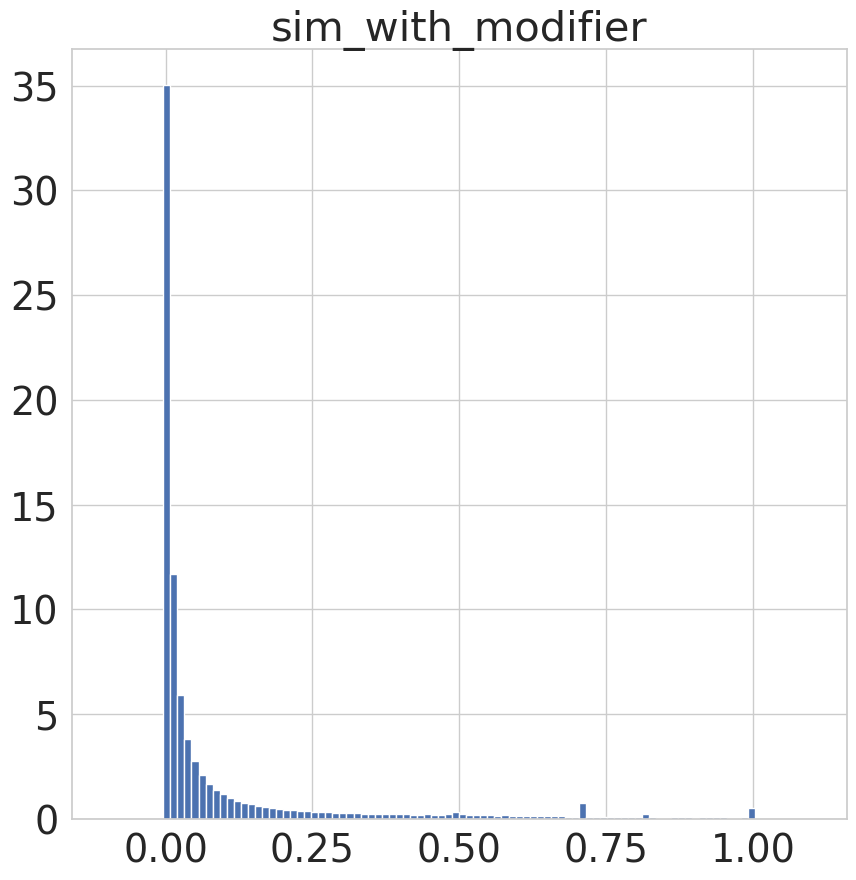

In [25]:
_=compound_modifier_sim.hist(column ='sim_with_modifier', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.1,1.1))

In [26]:
compound_head_sim=pd.merge(compounds,heads,on=["head","context",'time'])
compound_head_sim['numerator']=compound_head_sim['comp_count']*compound_head_sim['head_count']
compound_head_sim=compound_head_sim.groupby(['modifier','head','time'],observed=True)['numerator'].sum().to_frame()
compound_head_sim=pd.merge(compound_head_sim.reset_index(),compound_denom.reset_index(),on=["modifier","head",'time'])
compound_head_sim=pd.merge(compound_head_sim,head_denom.reset_index(),on=['head','time'])
compound_head_sim['sim_with_head']=compound_head_sim['numerator']/(compound_head_sim['compound_denom']*compound_head_sim['head_denom'])
compound_head_sim.set_index(['modifier','head','time'],inplace=True)
compound_head_sim.drop(['numerator','compound_denom'],axis=1,inplace=True)
compound_head_sim

,,,head_denom,sim_with_head
modifier,head,time,,
a,a,0,1.483704e+07,0.143105
aa,a,0,1.483704e+07,0.009316
aaa,a,0,1.483704e+07,0.016860
aad,a,0,1.483704e+07,0.000167
aagaard,a,0,1.483704e+07,0.026433
...,...,...,...,...
zygophylletum,dumosi,0,6.900000e+01,1.000000
zygophyllum,dumosum,0,1.310000e+02,0.890312
zygotic,mynci,0,2.120000e+02,1.000000


In [27]:
compound_head_sim.sim_with_head.describe()

count    8.624736e+06
mean     7.913859e-02
std      1.725411e-01
min      3.270873e-09
25%      1.836108e-03
50%      1.078830e-02
75%      5.539481e-02
max      1.000000e+00
Name: sim_with_head, dtype: float64

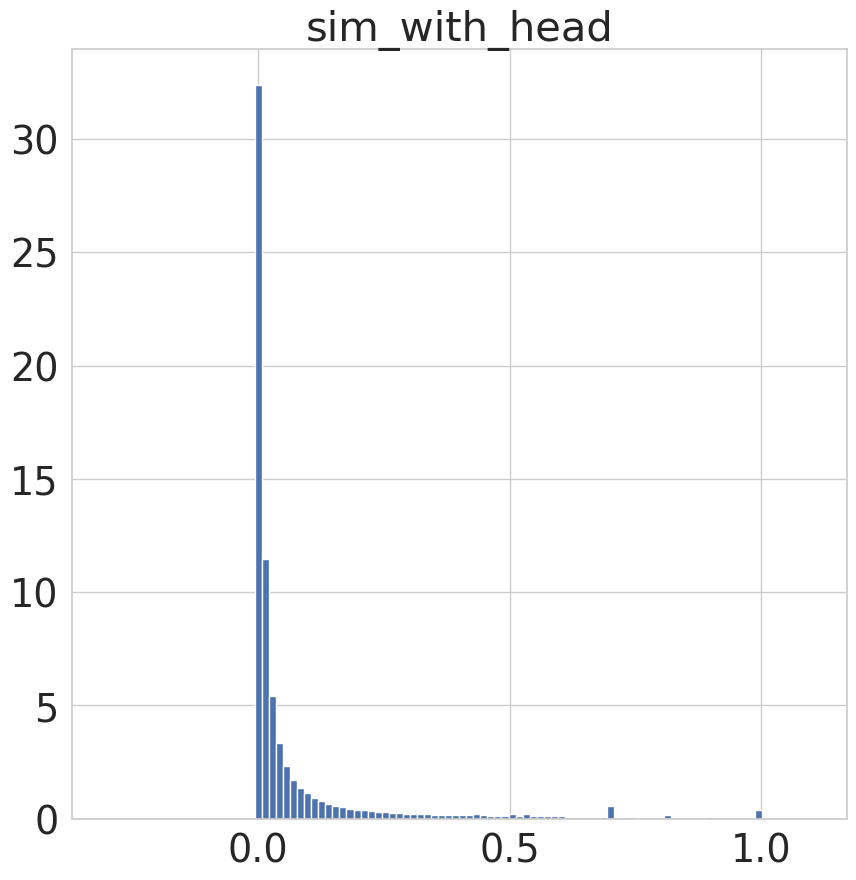

In [28]:
_=compound_head_sim.hist(column ='sim_with_head', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.3,1.1))

In [29]:
constituent_sim=pd.merge(heads,compounds,on=["head","context","time"])
#constituent_sim.drop('comp_count',axis=1,inplace=True)
constituent_sim=pd.merge(constituent_sim,modifiers,on=["modifier","context","time"])
constituent_sim['numerator']=constituent_sim['head_count']*constituent_sim['mod_count']
constituent_sim=constituent_sim.groupby(['modifier','head','time'],observed=True)['numerator'].sum().to_frame()
constituent_sim=pd.merge(constituent_sim.reset_index(),head_denom.reset_index(),on=["head","time"])
constituent_sim=pd.merge(constituent_sim,modifier_denom.reset_index(),on=["modifier","time"])
constituent_sim['sim_bw_constituents']=constituent_sim['numerator']/(constituent_sim['head_denom']*constituent_sim['modifier_denom'])
constituent_sim.set_index(['modifier','head','time'],inplace=True)
constituent_sim.drop(['numerator','modifier_denom','head_denom'],axis=1,inplace=True)
constituent_sim

sim_bw_constituents
modifier      head         time                     
a             a            0                0.100341
              aas          0                0.000015
              abbreviation 0                0.000009
              abc          0                0.000392
              abstract     0                0.001874
...                                              ...
zwy           aldouby      0                0.667256
zyanon        paznyak      0                1.000000
zyginidia     quyumi       0                1.000000
zygophylletum dumosi       0                1.000000
zygophyllum   dumosum      0                0.329209

[8365340 rows x 1 columns]

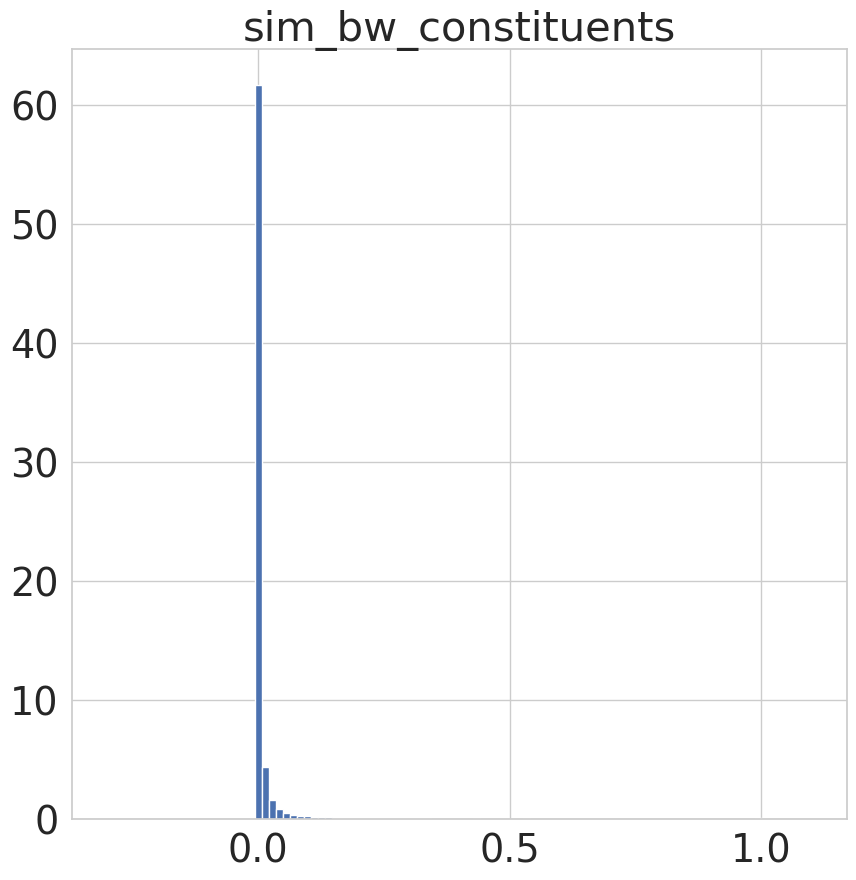

In [30]:
_=constituent_sim.hist(column ='sim_bw_constituents', figsize=(10, 10),bins=100,sharex=True,sharey=True,density=True,range=(-0.3,1.1))

In [31]:
dfs = [frequency_feat,constituent_sim, compound_head_sim.sim_with_head, compound_modifier_sim.sim_with_modifier, information_feat,productivity]
compounds_final = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True,how='outer'), dfs)

compounds_final=pd.pivot_table(compounds_final.reset_index(), index=['modifier','head'], columns=['time'])


compounds_final_1=compounds_final.columns.get_level_values(0)
compounds_final_2=compounds_final.columns.get_level_values(1)

cur_year=0
new_columns=[]
for year in compounds_final_2:
    new_columns.append(compounds_final_1[cur_year]+":"+str(year))
    cur_year+=1

compounds_final.columns=new_columns
compounds_final

comp_family_size:0  comp_freq:0  comp_prod:0  \
modifier      head                                                         
a             a                      23.085137      21644.0            1   
              aas                    23.085137         51.0            1   
              abbreviation           23.085137         67.0            1   
              abc                    23.085137        304.0            1   
              abstract               23.085137         60.0            1   
...                                        ...          ...          ...   
zzyzx         foundation             23.085137         86.0            1   
zzz           corporation            23.085137       1160.0            1   
zzzadditional research               23.085137       2882.0            1   
zzzing        sound                  23.085137        325.0            1   
zzzwgas       modified               23.085137         77.0            1   

                            comp_tf:0  const_prod:0  head_family_size:0  \
modifier      head                                                        
a             a             14.401746    125.566612           10.072861   
              aas            5.700440    243.851334           19.561575   
              abbreviation   6.087463    200.655691           16.096452   
              abc            8.252665    208.197276           16.701432   
              abstract       5.930737    173.247469           13.897784   
...                               ...           ...                 ...   
zzyzx         foundation     6.442943    235.040002           10.181443   
zzz           corporation   10.181152    254.422848           11.021067   
zzzadditional research      11.493355    256.273925           11.101252   
zzzing        sound          8.348728    298.250763           12.919601   
zzzwgas       modified       6.285402    419.096786           18.154399   

                            head_freq:0  head_prod:0  head_tf:0    local_mi:0  \
modifier      head                                                              
a             a              81003916.0        16523  26.271488  28784.644074   
              aas               16095.0           22  13.974415    249.788948   
              abbreviation     322873.0          253  18.300612     64.668670   
              abc              502395.0          166  18.938465    762.792864   
              abstract        5061534.0         1165  22.271144   -189.871833   
...                                 ...          ...        ...           ...   
zzyzx         foundation     29721120.0        15325  24.824985    913.840106   
zzz           corporation    79204352.0         8563  26.239076  10685.869565   
zzzadditional research      147653734.0         8100  27.137643  23959.190814   
zzzing        sound           9163626.0         2296  23.127487   4005.152366   
zzzwgas       modified          42610.0           60  15.378938   1545.553857   

                            ...  log_mod_freq:0   log_ratio:0  \
modifier      head          ...                                 
a             a             ...       13.199722  20012.827855   
              aas           ...       13.199722    357.577820   
              abbreviation  ...       13.199722     35.041529   
              abc           ...       13.199722    802.702598   
              abstract      ...       13.199722    999.559611   
...                         ...             ...           ...   
zzyzx         foundation    ...       29.008089   1827.680574   
zzz           corporation   ...       25.269881  21371.763589   
zzzadditional research      ...       23.957678  47918.462551   
zzzing        sound         ...       27.102305   8010.321347   
zzzwgas       modified      ...       29.165631   3091.308580   

                            mod_family_size:0  mod_freq:0  mod_prod:0  \
modifier      head                                                      
a             a  

In [154]:
compounds_final.columns

Index(['comp_family_size:0', 'comp_freq:0', 'comp_prod:0', 'comp_tf:0',
       'const_prod:0', 'head_family_size:0', 'head_freq:0', 'head_prod:0',
       'head_tf:0', 'local_mi:0', 'log_comp_freq:0', 'log_head_freq:0',
       'log_mod_freq:0', 'log_ratio:0', 'mod_family_size:0', 'mod_freq:0',
       'mod_prod:0', 'mod_tf:0', 'ppmi:0', 'sim_bw_constituents:0',
       'sim_with_head:0', 'sim_with_modifier:0', 'comp_freq_bins'],
      dtype='object')

In [171]:
plotdir = "compositionality_over_time/Plots/google/"
if args.contextual:
    comp_str='CompoundAware'
else:
    comp_str='CompoundAgnostic'
    
if args.tag:
    tag_str='Tagged'
else:
    tag_str='UnTagged'

print(f'Cutoff: {args.cutoff}')
print(f'Time span:  {args.temporal}')
temp_cutoff_str=str(args.temporal)+'_'+str(args.cutoff)

Cutoff: 0
Time span:  0


In [173]:
cur_ratings_df=compounds_final.reset_index().merge(compound_df,on=['modifier','head'])
cur_ratings_df

,modifier,head,comp_family_size:0,comp_freq:0,comp_prod:0,comp_tf:0,const_prod:0,head_family_size:0,head_freq:0,head_prod:0,...,sim_bw_constituents:0,sim_with_head:0,sim_with_modifier:0,comp_freq_bins,modifier_mean,modifier_std,head_mean,head_std,compound_mean,compound_std
0,academy,award,23.085137,727002.0,1,19.471602,182.631251,12.389473,12703613.0,3316,...,0.073359,0.218633,0.319099,compound,3.130400,1.632200,4.695700,1.473100,3.521700,1.473100
1,acid,test,23.085137,288301.0,1,18.137221,145.373405,11.404557,53924981.0,6564,...,0.021566,0.092589,0.089576,compound,0.714286,1.097307,3.896552,1.241379,1.222222,1.257079
2,agony,aunt,23.085137,2254.0,1,11.138912,293.517358,16.772254,144748.0,158,...,0.000764,0.012593,0.052941,compound,1.862069,1.224017,0.433333,0.558768,0.758621,0.857228
3,application,form,23.085137,7860605.0,1,22.906209,148.434640,11.146292,57145482.0,7851,...,0.115753,0.303718,0.211996,compound,4.766667,0.422953,4.862069,0.344828,4.800000,0.476095
4,arcade,game,23.085137,17322.0,1,14.080401,227.283862,13.042109,12371018.0,2109,...,0.032390,0.325963,0.174546,compound,3.760000,1.451400,4.680000,1.384400,3.800000,1.384400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,wedding,day,23.085137,385037.0,1,18.554641,173.684329,11.515756,62684212.0,6077,...,0.132460,0.090477,0.252329,compound,4.764700,0.562300,4.058800,0.242500,4.941200,0.242500
207,winter,solstice,23.085137,259229.0,1,17.983873,250.158925,19.692819,513465.0,20,...,0.052292,0.563257,0.160766,compound,5.000000,0.000000,4.681800,1.335500,4.545500,1.335500
208,word,painting,23.085137,7380.0,1,12.849601,153.112173,14.110722,4996794.0,1005,...,0.002698,0.019961,0.022617,compound,3.187500,1.558600,0.437500,1.310200,1.625000,1.310200
209,world,conference,23.085137,1669189.0,1,20.670717,138.510530,11.915212,73159356.0,4607,...,0.023069,0.158577,0.023018,compound,3.875000,1.361300,4.291700,1.366700,3.958300,1.366700


Log Frequency


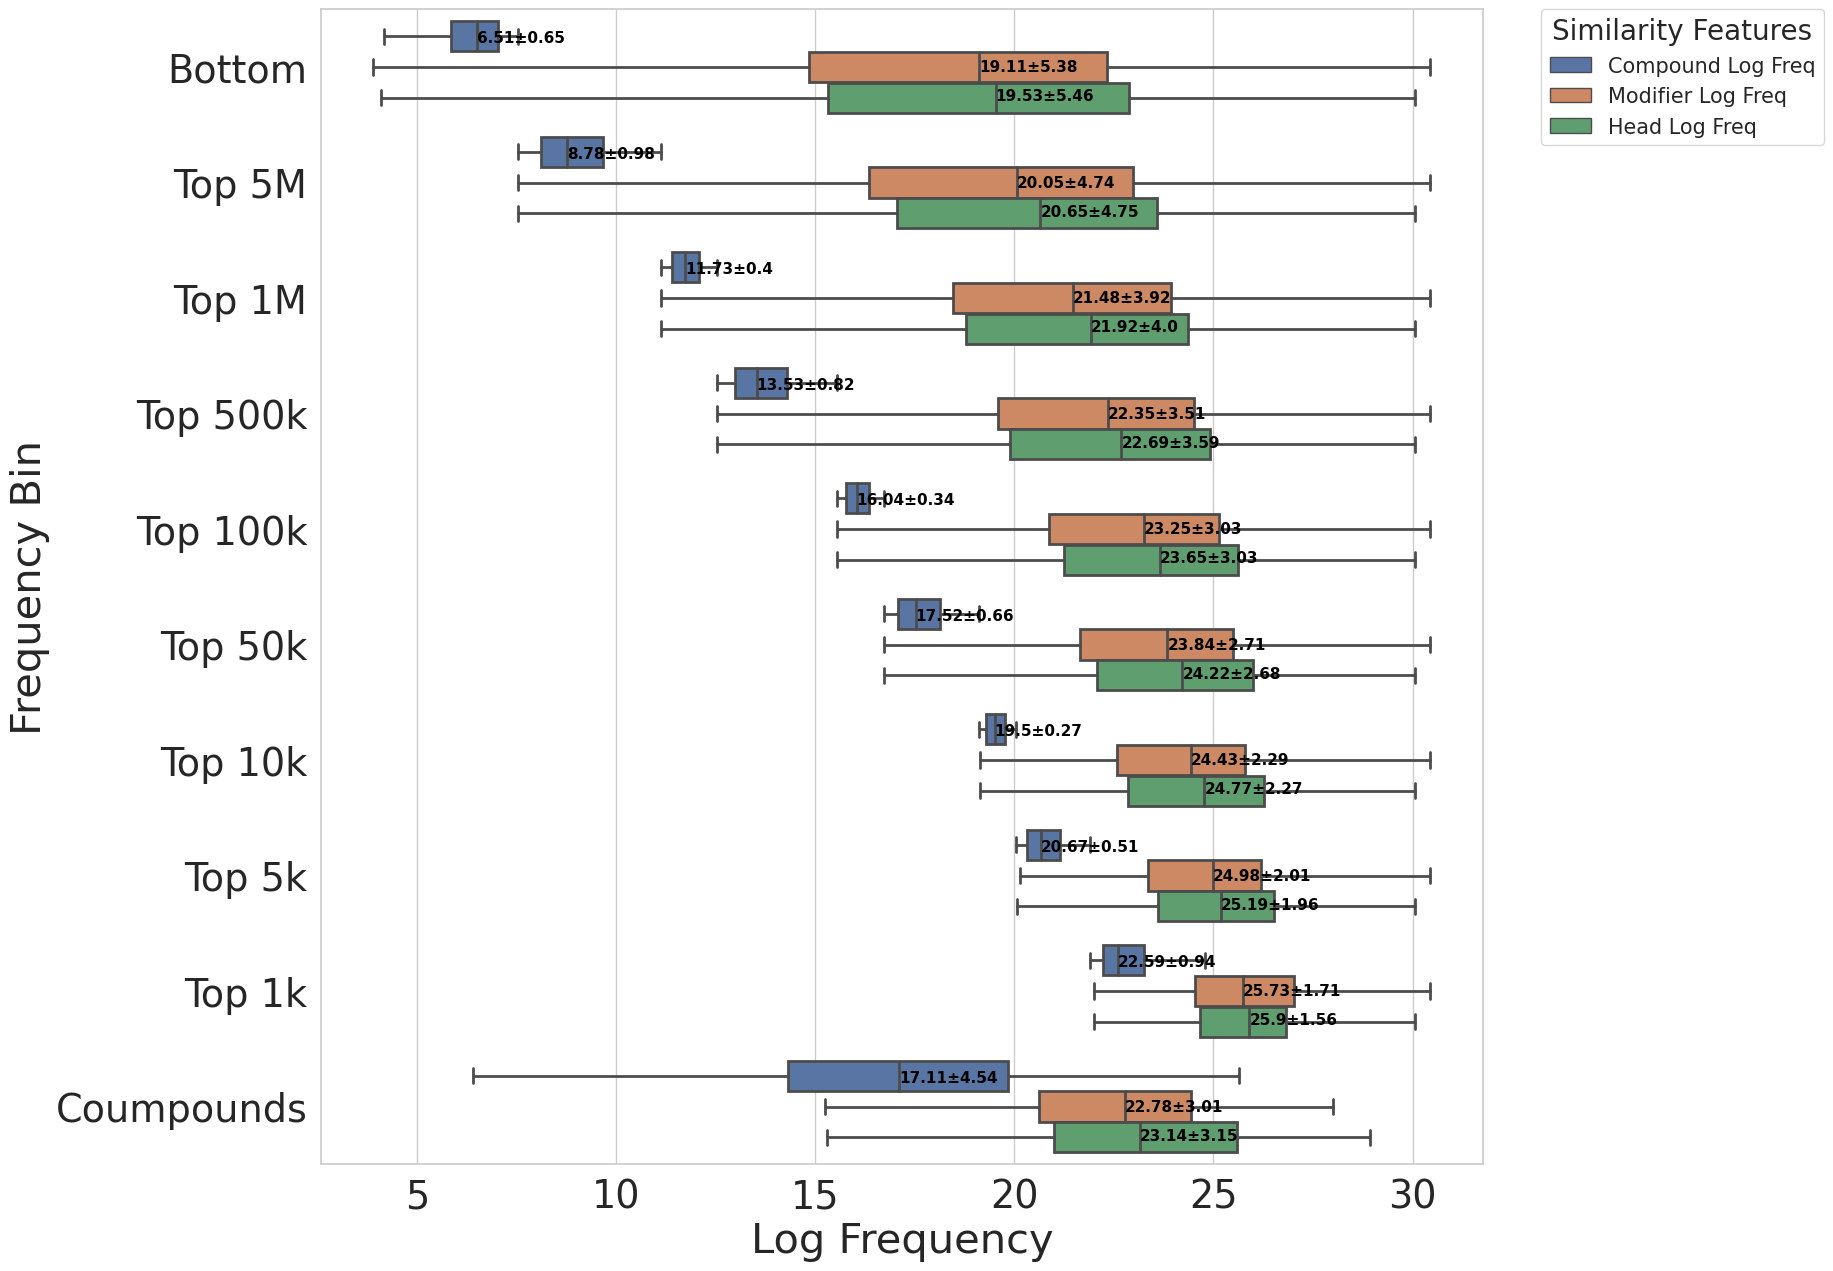

Family Size Features


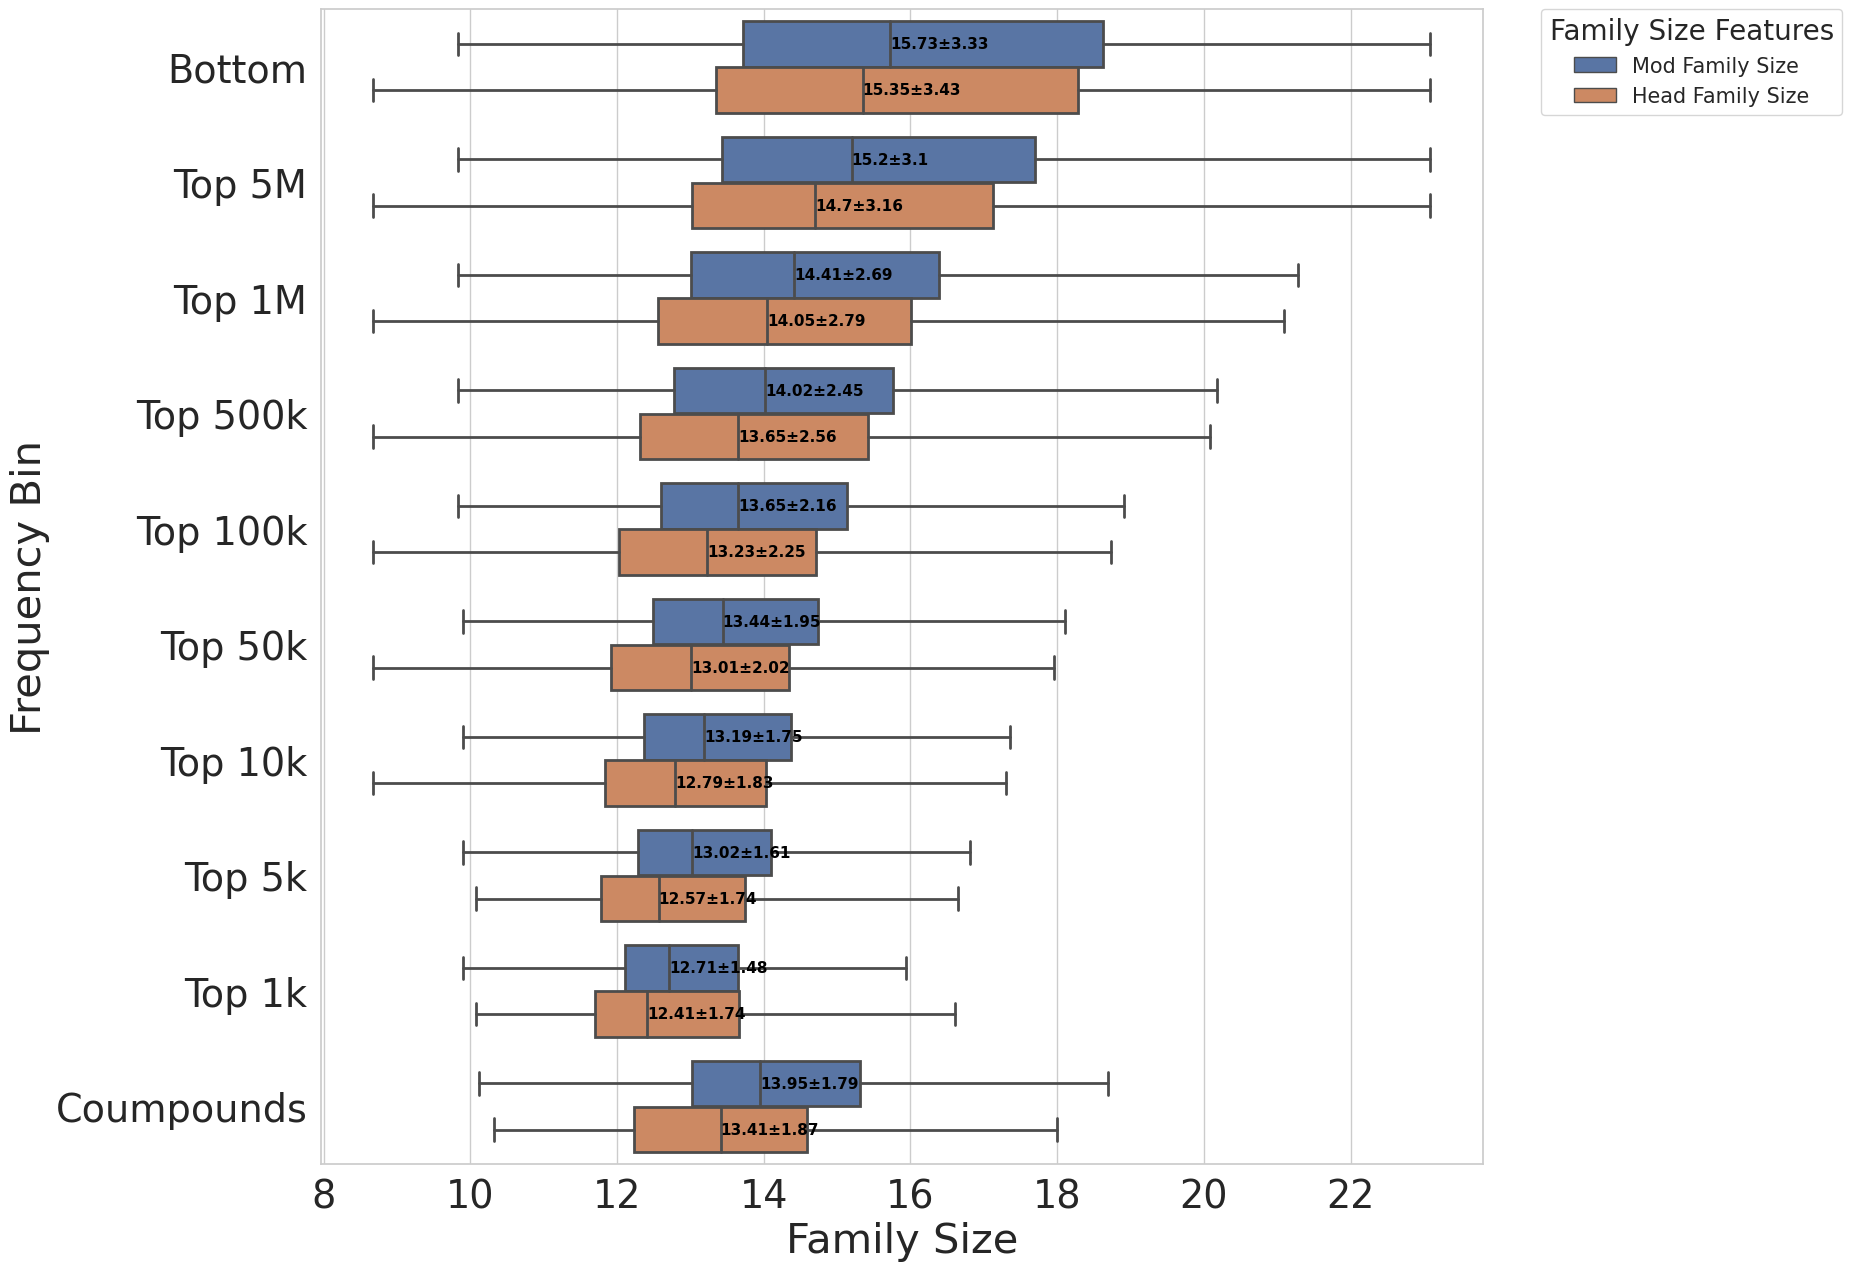

Productivity Features


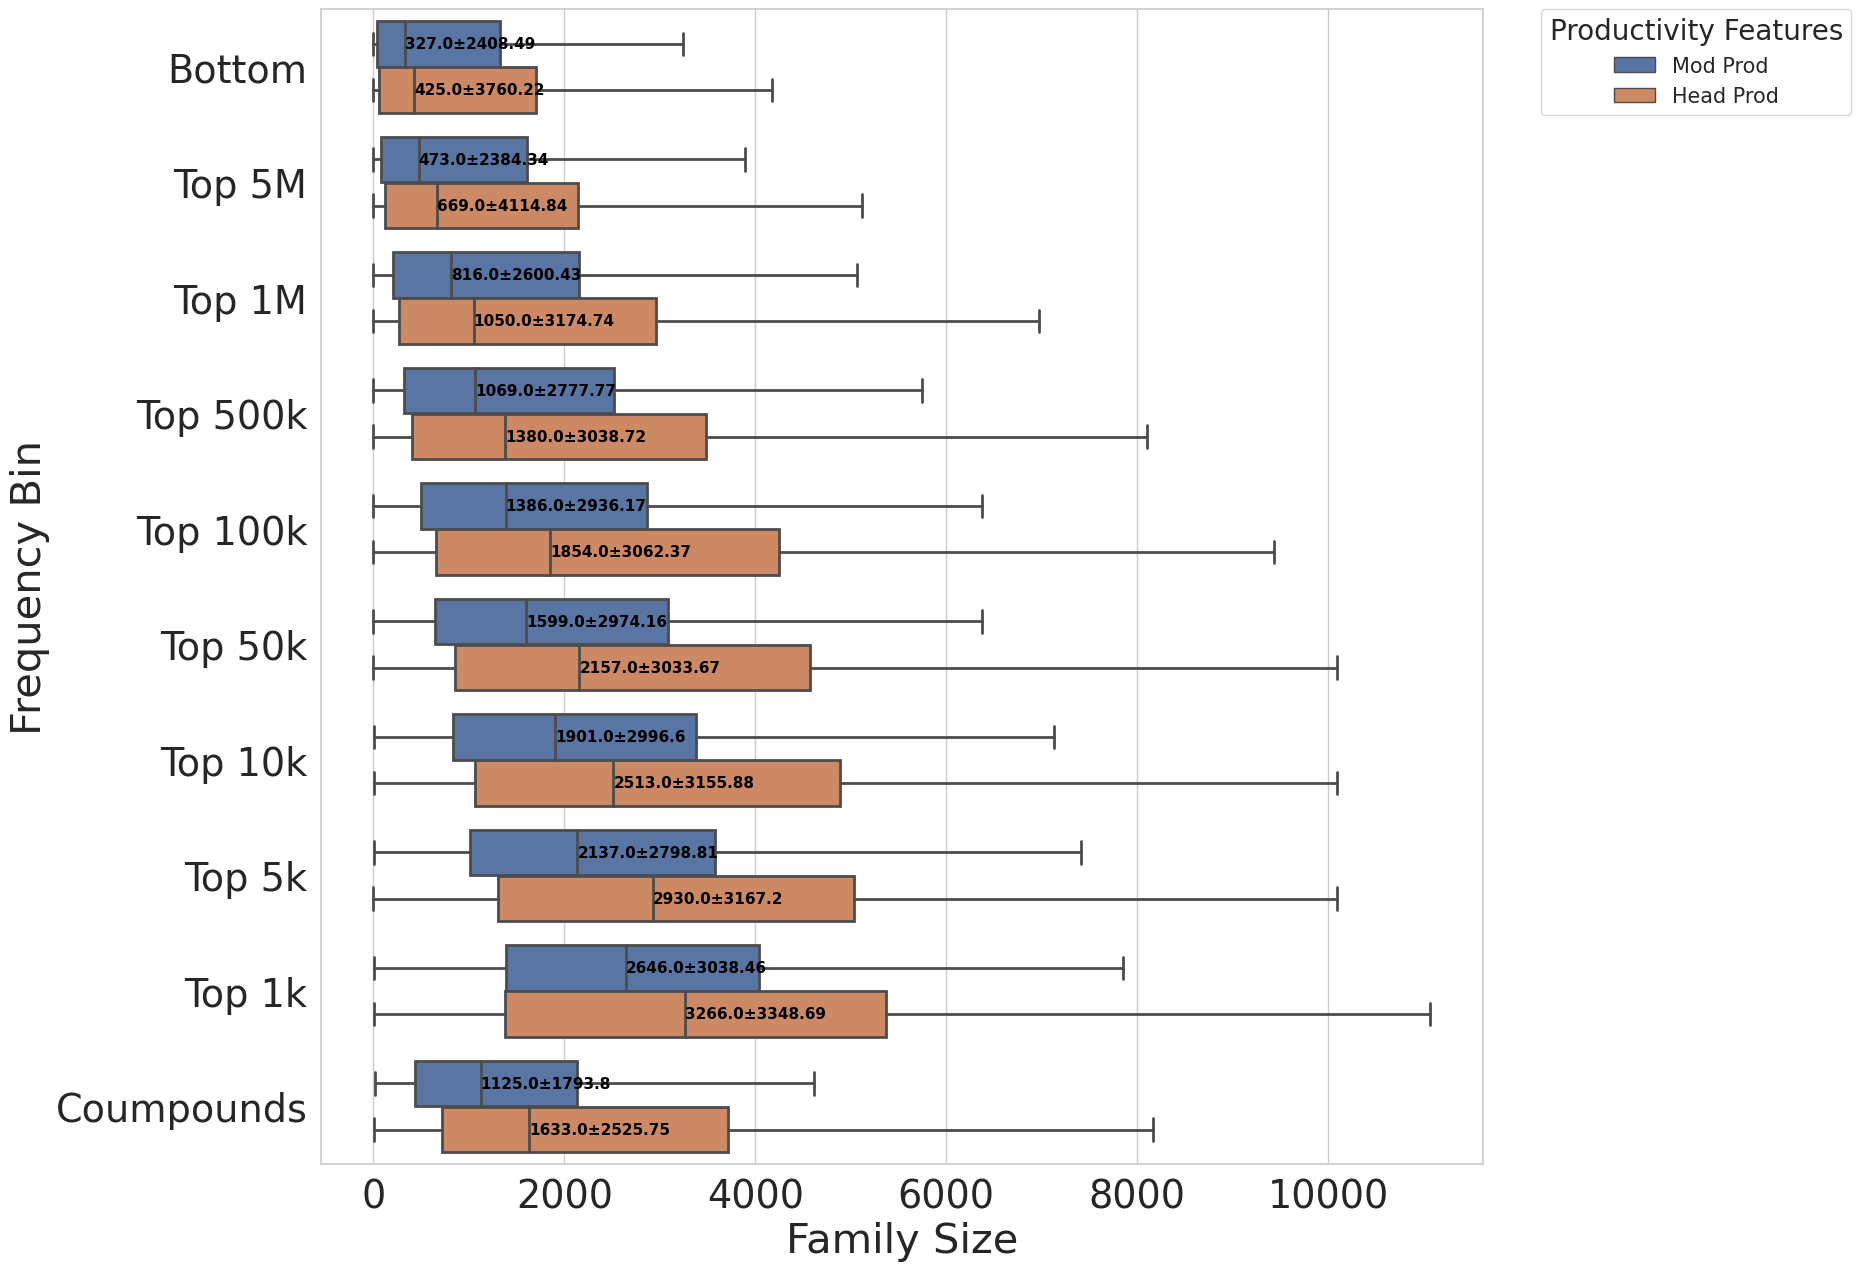

PPMI


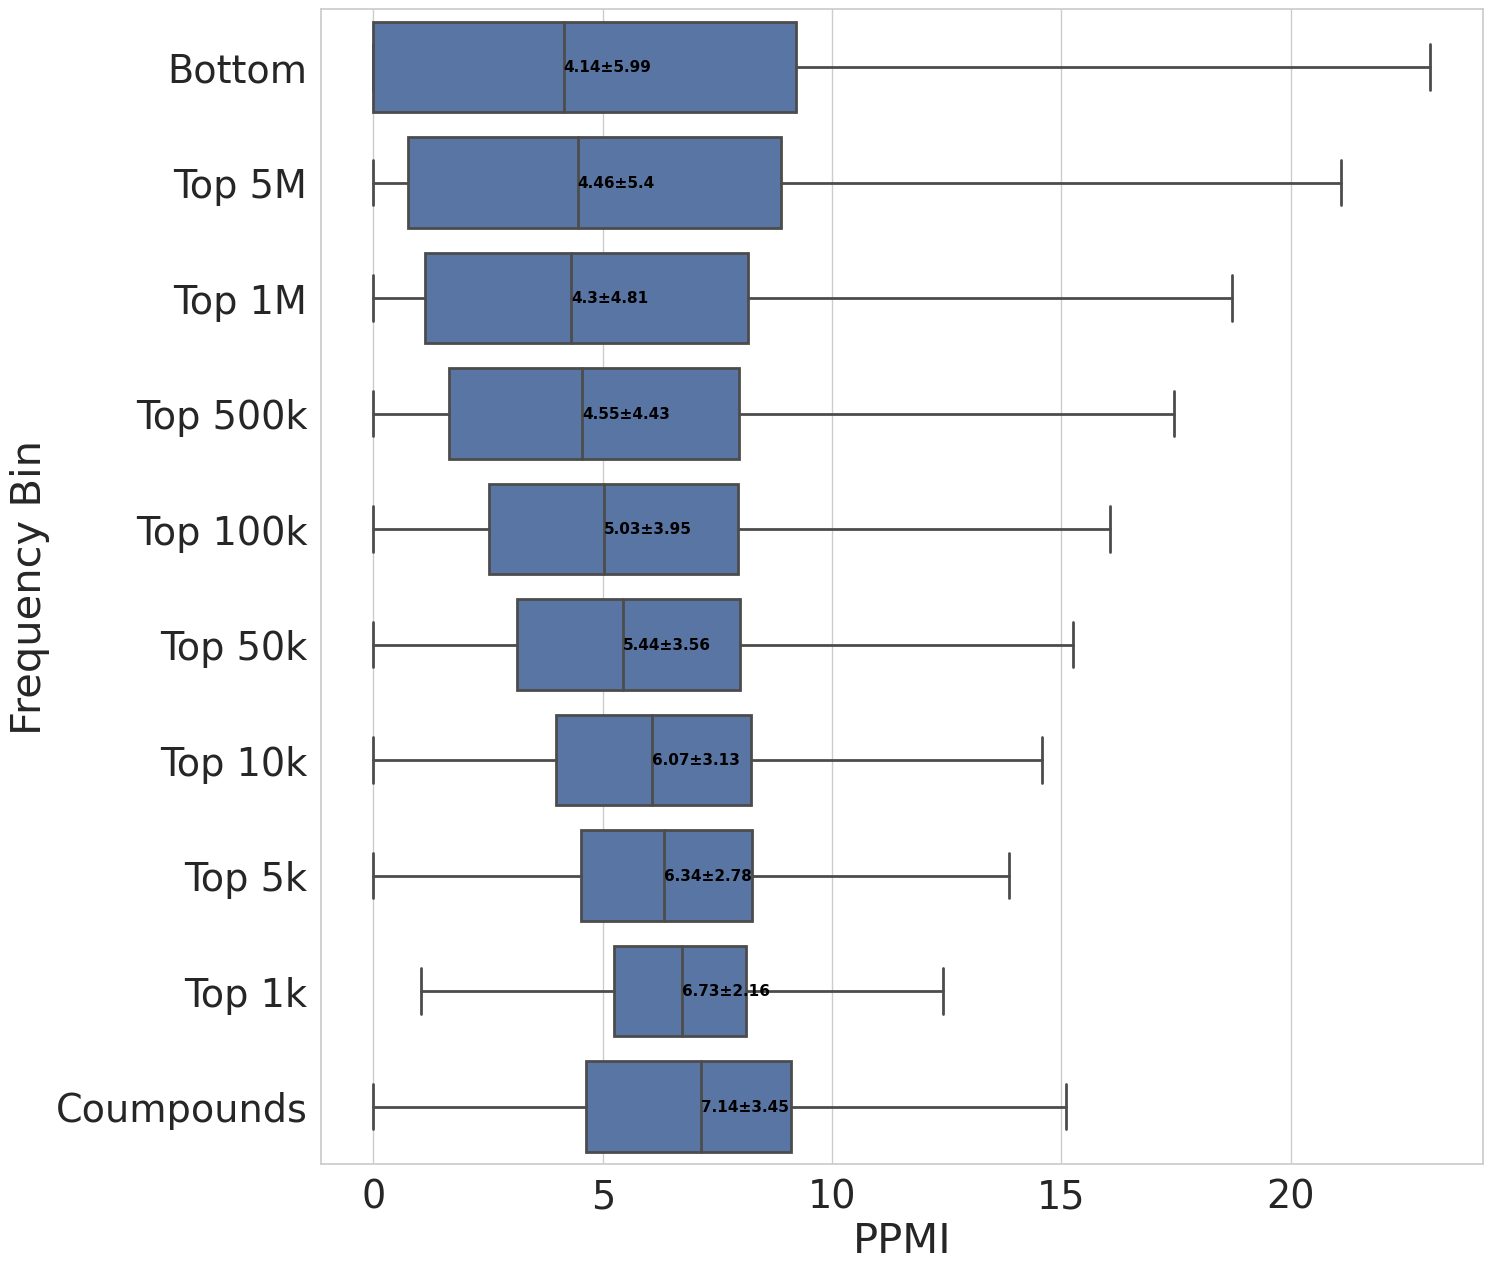

Cosine Features


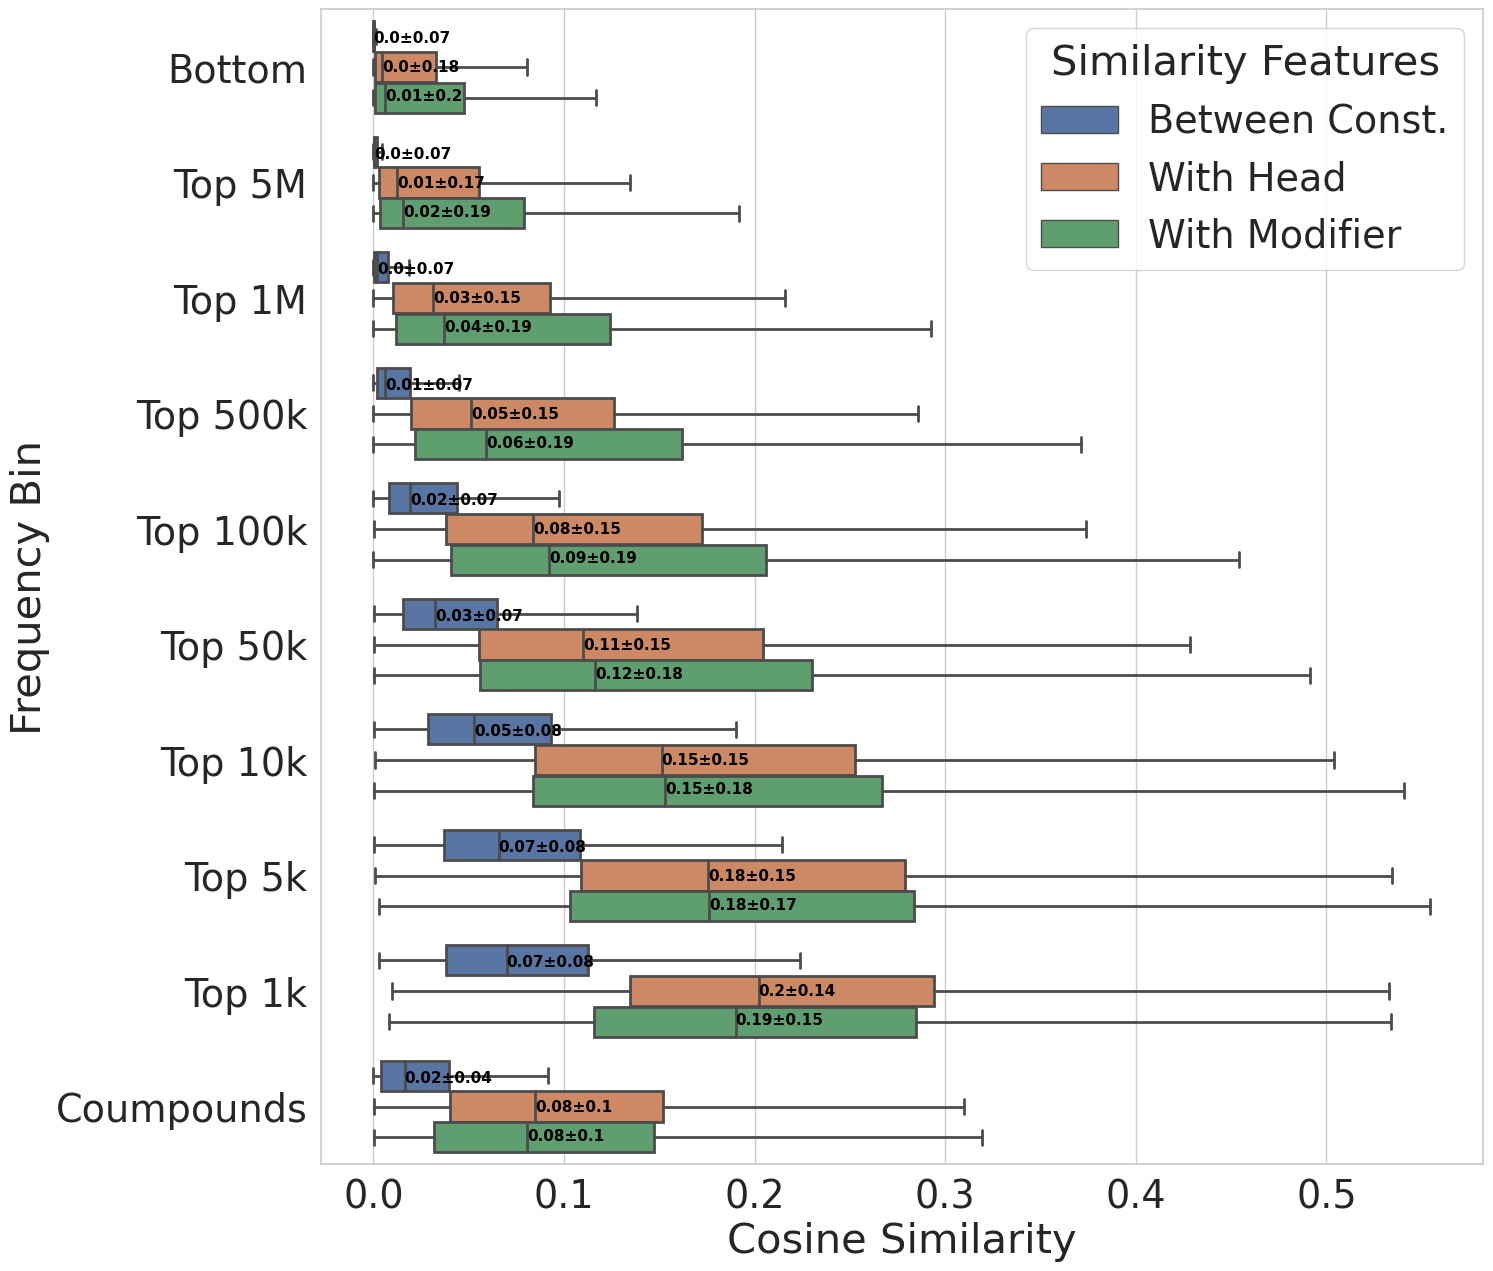

In [172]:
if args.temporal==0:
    qcut_bins=[1]
    for cur_freq_count in top_freq_counts:
        qcut_bins.append(1-cur_freq_count/compounds_final.shape[0])
    qcut_bins.reverse()
    qcut_labels=['top1k','top5k','top10k','top50k','top100k','top500k','top1m','top5m','bottom']
    qcut_labels.reverse()

    compounds_final['comp_freq_bins']=pd.qcut(compounds_final['comp_freq:0'],q=qcut_bins,labels=qcut_labels,duplicates='drop')
    compounds_final['comp_freq_bins']=compounds_final['comp_freq_bins'].astype(object)
    compounds_final.loc[pd.MultiIndex.from_frame(compound_df[['modifier','head']]),"comp_freq_bins"]="compound"
    compounds_final['comp_freq_bins']=compounds_final['comp_freq_bins'].astype('category')
    compounds_final.comp_freq_bins.value_counts()
    qcut_labels.append('compound')
    
    
    print('Log Frequency')
    
    to_select_cols=['comp_tf:0','mod_tf:0','head_tf:0']
    new_labels=['Compound Log Freq','Modifier Log Freq','Head Log Freq']
    plot_freq_df=compounds_final.reset_index().melt(id_vars=['comp_freq_bins'],value_vars=to_select_cols)
    plot_freq_df['variable'] = plot_freq_df['variable'].map(dict(zip(to_select_cols,new_labels)))

    plt.figure(figsize=(15,15))
    g=sns.boxplot(data=plot_freq_df, x="value", y="comp_freq_bins",hue='variable',order=qcut_labels,dodge=True,showfliers = False)
    g.set_xlabel("Log Frequency")
    g.set_ylabel("Percentile Bin")
    g.set_yticklabels(['Bottom','Top 5M','Top 1M','Top 500k','Top 100k','Top 50k','Top 10k','Top 5k','Top 1k','Coumpounds'])

    med_values = plot_freq_df.groupby(['variable','comp_freq_bins'])['value'].median()
    std_dev_values= plot_freq_df.groupby(['variable','comp_freq_bins'])['value'].std()

    i=0
    for ytick in g.get_yticks():

        g.text(med_values[new_labels[0],qcut_labels[i]],ytick-0.25,f"{round(med_values[new_labels[0],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[0],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        g.text(med_values[new_labels[1],qcut_labels[i]],ytick,f"{round(med_values[new_labels[1],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[1],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        g.text(med_values[new_labels[2],qcut_labels[i]],ytick+0.25,f"{round(med_values[new_labels[2],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[2],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        i+=1
    
    g.legend(title='Similarity Features', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15,title_fontsize=20)

    plt.savefig(f'{plotdir}/log_feature_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

    plt.show()
    
    print('Family Size Features')
    
    
    to_select_cols=['mod_family_size:0','head_family_size:0']
    new_labels=['Mod Family Size','Head Family Size']
    plot_family_size_df=compounds_final.reset_index().melt(id_vars=['comp_freq_bins'],value_vars=to_select_cols)
    plot_family_size_df['variable'] = plot_family_size_df['variable'].map(dict(zip(to_select_cols,new_labels)))

    plt.figure(figsize=(15,15))
    g=sns.boxplot(data=plot_family_size_df, x="value", y="comp_freq_bins",hue='variable',order=qcut_labels,dodge=True,showfliers = False)
    g.set_xlabel("Family Size")
    g.set_ylabel("Percentile Bin")
    g.set_yticklabels(['Bottom','Top 5M','Top 1M','Top 500k','Top 100k','Top 50k','Top 10k','Top 5k','Top 1k','Coumpounds'])

    med_values = plot_family_size_df.groupby(['variable','comp_freq_bins'])['value'].median()
    std_dev_values= plot_family_size_df.groupby(['variable','comp_freq_bins'])['value'].std()

    i=0
    for ytick in g.get_yticks():

        g.text(med_values[new_labels[0],qcut_labels[i]],ytick-0.2,f"{round(med_values[new_labels[0],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[0],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        g.text(med_values[new_labels[1],qcut_labels[i]],ytick+0.2,f"{round(med_values[new_labels[1],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[1],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        #g.text(med_values[new_labels[2],qcut_labels[i]],ytick+0.25,f"{round(med_values[new_labels[2],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[2],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        i+=1
    
    g.legend(title='Family Size Features', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15,title_fontsize=20)

    plt.savefig(f'{plotdir}/family_size_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

    plt.show()
    
    print('Productivity Features')
    
    to_select_cols=['mod_prod:0','head_prod:0']
    new_labels=['Mod Prod','Head Prod']
    plot_prod_df=compounds_final.reset_index().melt(id_vars=['comp_freq_bins'],value_vars=to_select_cols)
    plot_prod_df['variable'] = plot_prod_df['variable'].map(dict(zip(to_select_cols,new_labels)))

    plt.figure(figsize=(15,15))
    g=sns.boxplot(data=plot_prod_df, x="value", y="comp_freq_bins",hue='variable',order=qcut_labels,dodge=True,showfliers = False)
    g.set_xlabel("Family Size")
    g.set_ylabel("Percentile Bin")
    g.set_yticklabels(['Bottom','Top 5M','Top 1M','Top 500k','Top 100k','Top 50k','Top 10k','Top 5k','Top 1k','Coumpounds'])

    med_values = plot_prod_df.groupby(['variable','comp_freq_bins'])['value'].median()
    std_dev_values= plot_prod_df.groupby(['variable','comp_freq_bins'])['value'].std()

    i=0
    for ytick in g.get_yticks():

        g.text(med_values[new_labels[0],qcut_labels[i]],ytick-0.2,f"{round(med_values[new_labels[0],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[0],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        g.text(med_values[new_labels[1],qcut_labels[i]],ytick+0.2,f"{round(med_values[new_labels[1],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[1],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        #g.text(med_values[new_labels[2],qcut_labels[i]],ytick+0.25,f"{round(med_values[new_labels[2],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[2],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        i+=1
    
    g.legend(title='Productivity Features', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15,title_fontsize=20)

    plt.savefig(f'{plotdir}/prod_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

    plt.show()
    
    print('PPMI')
    
    to_select_cols=['ppmi:0']
    new_labels=['PPMI']
    plot_ppmi_df=compounds_final.reset_index().melt(id_vars=['comp_freq_bins'],value_vars=to_select_cols)
    plot_ppmi_df['variable'] = plot_ppmi_df['variable'].map(dict(zip(to_select_cols,new_labels)))

    plt.figure(figsize=(15,15))
    g=sns.boxplot(data=plot_ppmi_df, x="value", y="comp_freq_bins",hue='variable',order=qcut_labels,dodge=True,showfliers = False)
    g.set_xlabel("PPMI")
    g.set_ylabel("Percentile Bin")
    g.set_yticklabels(['Bottom','Top 5M','Top 1M','Top 500k','Top 100k','Top 50k','Top 10k','Top 5k','Top 1k','Coumpounds'])

    med_values = plot_ppmi_df.groupby(['variable','comp_freq_bins'])['value'].median()
    std_dev_values= plot_ppmi_df.groupby(['variable','comp_freq_bins'])['value'].std()

    i=0
    for ytick in g.get_yticks():

        g.text(med_values[new_labels[0],qcut_labels[i]],ytick,f"{round(med_values[new_labels[0],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[0],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        #g.text(med_values[new_labels[1],qcut_labels[i]],ytick+0.2,f"{round(med_values[new_labels[1],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[1],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        #g.text(med_values[new_labels[2],qcut_labels[i]],ytick+0.25,f"{round(med_values[new_labels[2],qcut_labels[i]],2)}±{round(std_dev_values[new_labels[2],qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        i+=1
    
    #g.legend(title='PPMI Features', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=15,title_fontsize=20)
    g.get_legend().remove()
    plt.savefig(f'{plotdir}/ppmi_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

    plt.show()
    
    print('Cosine Features')
    
    to_select_cols=['sim_bw_constituents:0','sim_with_head:0','sim_with_modifier:0']
    new_labels=['Between Const.', 'With Head','With Modifier']
    
    plot_cos_df=compounds_final.reset_index().melt(id_vars=['comp_freq_bins'],value_vars=to_select_cols)
    plot_cos_df['variable'] = plot_cos_df['variable'].map(dict(zip(to_select_cols,new_labels)))

    plt.figure(figsize=(15,15))
    g=sns.boxplot(data=plot_cos_df, x="value", y="comp_freq_bins",hue='variable',order=qcut_labels,dodge=True,showfliers = False)
    g.set_xlabel("Cosine Similarity")
    g.set_ylabel("Percentile Bin")
    g.set_yticklabels(['Bottom','Top 5M','Top 1M','Top 500k','Top 100k','Top 50k','Top 10k','Top 5k','Top 1k','Coumpounds'])

    med_values = plot_cos_df.groupby(['variable','comp_freq_bins'])['value'].median()
    std_dev_values= plot_cos_df.groupby(['variable','comp_freq_bins'])['value'].std()

    i=0
    for ytick in g.get_yticks():

        g.text(med_values['Between Const.',qcut_labels[i]],ytick-0.25,f"{round(med_values['Between Const.',qcut_labels[i]],2)}±{round(std_dev_values['Between Const.',qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        g.text(med_values['With Head',qcut_labels[i]],ytick,f"{round(med_values['With Head',qcut_labels[i]],2)}±{round(std_dev_values['With Head',qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        g.text(med_values['With Modifier',qcut_labels[i]],ytick+0.25,f"{round(med_values['With Modifier',qcut_labels[i]],2)}±{round(std_dev_values['With Modifier',qcut_labels[i]],2)}", va='center',size=11,color='black',weight='semibold')
        i+=1
    
    plt.legend(title='Similarity Features', loc='upper right')

    plt.savefig(f'{plotdir}/cosine_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

    plt.show()
    
else:
    compounds_complete_index=compounds_final.index
    print(len(compounds_complete_index))

    compound_pivot=pd.pivot_table(constituent_sim,columns='time',index=['modifier','head'],values='sim_bw_constituents')
    compounds_all_index=compound_pivot.dropna().index
    print(len(compounds_all_index))
    #temp_list=list(product(compounds_decades_all.values,compound_pivot.columns))
    #compounds_decades_all_index=[(x[0],x[1],y) for x,y in temp_list]


    columns_names_1900_end=compound_pivot.columns[compound_pivot.columns>=1900]
    compounds_1900_end_index=compound_pivot.loc[:,columns_names_1900_end].dropna().index
    print(len(compounds_1900_end_index))
    #temp_list=list(product(compounds_decades_1900_end.values,columns_names_1900_end))
    #compounds_decades_1900_end_index=[(x[0],x[1],y) for x,y in temp_list]

    columns_names_1950_end=compound_pivot.columns[compound_pivot.columns>=1950]
    compounds_1950_end_index=compound_pivot.loc[:,columns_names_1950_end].dropna().index
    print(len(compounds_1950_end_index))
    #temp_list=list(product(compounds_decades_1950_end.values,columns_names_1950_end))
    #compounds_decades_1950_end_index=[(x[0],x[1],y) for x,y in temp_list]


    columns_names_2000_end=compound_pivot.columns[compound_pivot.columns>=2000]
    compounds_2000_end_index=compound_pivot.loc[:,columns_names_2000_end].dropna().index
    print(len(compounds_2000_end_index))
    #temp_list=list(product(compounds_decades_2000_end.values,columns_names_2000_end))
    #compounds_decades_2000_end_index=[(x[0],x[1],y) for x,y in temp_list]
    compound_index_lst=[compounds_complete_index,compounds_decades_all_index,compounds_decades_1900_end_index,compounds_decades_1950_end_index,compounds_decades_2000_end_index]
    tags_lst=['complete','all','1900','1950','2000']
    
    
    for cur_index_lst,cur_tag in zip(compound_index_lst,tags_lst):

        print(cur_tag)
        cur_df=compounds_final.loc[cur_index_lst]

        cur_ratings_df=cur_df.reset_index().merge(compound_df,on=['modifier','head'])
        print(cur_ratings_df.shape)

        print('Raw frequency features')
        to_select_cols_1=[col for col in cur_df if col.startswith('comp_freq')]
        to_select_cols_2=[col for col in cur_df if col.startswith('mod_freq')]
        to_select_cols_3=[col for col in cur_df if col.startswith('head_freq')]
        to_select_cols=to_select_cols_1+to_select_cols_2+to_select_cols_3

        plot_freq_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
        plot_freq_df[['variable','time']]=plot_freq_df['variable'].str.split(':',expand=True)


        plt.figure(figsize=(15,15))
        g=sns.lineplot(x="time", y="value", hue="variable",data=plot_freq_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
        g.legend(loc='upper left')
        g.set_xlabel("Time")
        g.set_ylabel("Frequency")
        plt.setp(g.get_xticklabels(), rotation=60)
        plt.savefig(f'{plotdir}/freq_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


        plot_freq_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
        plot_freq_ratings_df[['variable','time']]=plot_freq_ratings_df['variable'].str.split(':',expand=True)
        plt.figure(figsize=(15,15))
        g=sns.lineplot(x="time", y="value", hue="variable",data=plot_freq_all_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
        g.legend(loc='upper left')
        g.set_xlabel("Time")
        g.set_ylabel("Frequency")
        plt.setp(g.get_xticklabels(), rotation=60)
        plt.savefig(f'{plotdir}/freq_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


        print('Log frequency features')

        to_select_cols_1=[col for col in cur_df if col.startswith('comp_tf')]
        to_select_cols_2=[col for col in cur_df if col.startswith('mod_tf')]
        to_select_cols_3=[col for col in cur_df if col.startswith('head_tf')]
        to_select_cols=to_select_cols_1+to_select_cols_2+to_select_cols_3

        plot_tf_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
        plot_tf_df[['variable','time']]=plot_tf_df['variable'].str.split(':',expand=True)

        plt.figure(figsize=(15,15))
        g=sns.lineplot(x="time", y="value", hue="variable",data=plot_tf_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
        g.legend(loc='upper left')
        g.set_xlabel("Time")
        g.set_ylabel("Log Frequency")
        plt.setp(g.get_xticklabels(), rotation=60)
        plt.savefig(f'{plotdir}/log_freq_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


        plot_tf_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
        plot_tf_ratings_df[['variable','time']]=plot_tf_ratings_df['variable'].str.split(':',expand=True)
        plt.figure(figsize=(15,15))
        g=sns.lineplot(x="time", y="value", hue="variable",data=plot_tf_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
        g.legend(loc='upper left')
        g.set_xlabel("Time")
        g.set_ylabel("Log Frequency")
        plt.setp(g.get_xticklabels(), rotation=60)
        plt.savefig(f'{plotdir}/log_freq_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


        print('Family size')

        to_select_cols_1=[col for col in cur_df if col.startswith('mod_family_size')]
        to_select_cols_2=[col for col in cur_df if col.startswith('head_family_size')]
        to_select_cols=to_select_cols_1+to_select_cols_2

        plot_family_size_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
        plot_family_size_df[['variable','time']]=plot_family_size_df['variable'].str.split(':',expand=True)

        plt.figure(figsize=(15,15))
        g=sns.lineplot(x="time", y="value", hue="variable",data=plot_family_size_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
        g.legend(loc='upper left')
        g.set_xlabel("Time")
        g.set_ylabel("Family Size")
        plt.setp(g.get_xticklabels(), rotation=60)
        plt.savefig(f'{plotdir}/family_size_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

        plot_family_size_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
        plot_family_size_ratings_df[['variable','time']]=plot_family_size_ratings_df['variable'].str.split(':',expand=True)
        plt.figure(figsize=(15,15))
        g=sns.lineplot(x="time", y="value", hue="variable",data=plot_family_size_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
        g.legend(loc='upper left')
        g.set_xlabel("Time")
        g.set_ylabel("Family Size")
        plt.setp(g.get_xticklabels(), rotation=60)
        plt.savefig(f'{plotdir}/family_size_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

        print('Productivity')

        to_select_cols_1=[col for col in cur_df if col.startswith('mod_prod')]
        to_select_cols_2=[col for col in cur_df if col.startswith('head_prod')]
        to_select_cols=to_select_cols_1+to_select_cols_2


        plot_prod_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
        plot_prod_df[['variable','time']]=plot_prod_df['variable'].str.split(':',expand=True)

        plt.figure(figsize=(15,15))
        g=sns.lineplot(x="time", y="value", hue="variable",data=plot_prod_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
        g.legend(loc='upper left')
        g.set_xlabel("Time")
        g.set_ylabel("Productivity")
        plt.setp(g.get_xticklabels(), rotation=60)
        plt.savefig(f'{plotdir}/prod_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


        plot_prod_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
        plot_prod_ratings_df[['variable','time']]=plot_prod_ratings_df['variable'].str.split(':',expand=True)
        plt.figure(figsize=(15,15))
        g=sns.lineplot(x="time", y="value", hue="variable",data=plot_prod_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
        g.legend(loc='upper left')
        g.set_xlabel("Time")
        g.set_ylabel("Productivity")
        plt.setp(g.get_xticklabels(), rotation=60)
        plt.savefig(f'{plotdir}/prod_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


        print('Information Theory')

        to_select_cols_1=[col for col in compounds_decades_all_df if col.startswith('log_ratio')]
        to_select_cols_2=[col for col in compounds_decades_all_df if col.startswith('local_mi')]

        plot_log_ratio_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols_1)
        plot_log_ratio_df[['variable','time']]=plot_log_ratio_df['variable'].str.split(':',expand=True)

        plt.figure(figsize=(15,15))
        g=sns.lineplot(x="time", y="value", hue="variable",data=plot_log_ratio_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
        g.legend(loc='upper left')
        g.set_xlabel("Time")
        g.set_ylabel("Log Ratio")
        plt.setp(g.get_xticklabels(), rotation=60)
        plt.savefig(f'{plotdir}/log_ratio_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

        plot_lmi_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols_2)
        plot_lmi_df[['variable','time']]=plot_lmi_df['variable'].str.split(':',expand=True)

        plt.figure(figsize=(15,15))
        g=sns.lineplot(x="time", y="value", hue="variable",data=plot_lmi_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
        g.legend(loc='upper left')
        g.set_xlabel("Time")
        g.set_ylabel("Local MI")
        plt.setp(g.get_xticklabels(), rotation=60)
        plt.savefig(f'{plotdir}/lmi_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)


        plot_log_ratio_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols_1)
        plot_log_ratio_ratings_df[['variable','time']]=plot_log_ratio_ratings_df['variable'].str.split(':',expand=True)

        plt.figure(figsize=(15,15))
        g=sns.lineplot(x="time", y="value", hue="variable",data=plot_log_ratio_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
        g.legend(loc='upper left')
        g.set_xlabel("Time")
        g.set_ylabel("Log Ratio")
        plt.setp(g.get_xticklabels(), rotation=60)
        plt.savefig(f'{plotdir}/log_ratio_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

        plot_lmi_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols_2)
        plot_lmi_ratings_df[['variable','time']]=plot_lmi_ratings_df['variable'].str.split(':',expand=True)

        plt.figure(figsize=(15,15))
        g=sns.lineplot(x="time", y="value", hue="variable",data=plot_lmi_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
        g.legend(loc='upper left')
        g.set_xlabel("Time")
        g.set_ylabel("Local MI")
        plt.setp(g.get_xticklabels(), rotation=60)
        plt.savefig(f'{plotdir}/lmi_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

        print('Cosine')
        to_select_cols_1=[col for col in compounds_decades_all_df if col.startswith('sim_with_modifier')]
        to_select_cols_2=[col for col in compounds_decades_all_df if col.startswith('sim_with_head')]
        to_select_cols_3=[col for col in compounds_decades_all_df if col.startswith('sim_bw_constituents')]
        to_select_cols=to_select_cols_1+to_select_cols_2+to_select_cols_3

        plot_cosine_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
        plot_cosine_df[['variable','time']]=plot_cosine_df['variable'].str.split(':',expand=True)

        plt.figure(figsize=(15,15))
        g=sns.lineplot(x="time", y="value", hue="variable",data=plot_cosine_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
        g.legend(loc='upper right')
        g.set_xlabel("Time")
        g.set_ylabel("Cosine Similarity")
        plt.setp(g.get_xticklabels(), rotation=60)
        plt.savefig(f'{plotdir}/cosine_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

        plot_cosine_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
        plot_cosine_ratings_df[['variable','time']]=plot_cosine_ratings_df['variable'].str.split(':',expand=True)
        plt.figure(figsize=(15,15))
        g=sns.lineplot(x="time", y="value", hue="variable",data=plot_cosine_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
        g.legend(loc='upper left')
        g.set_xlabel("Time")
        g.set_ylabel("Cosine Similarity")
        plt.setp(g.get_xticklabels(), rotation=60)
        plt.savefig(f'{plotdir}/cosine_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

        print('Saving the dataset')

        cur_ratings_df.to_csv(f'{args.inputdir}/features_all_{cur_tag}_{comp_str}_{tag_str}_{temp_cutoff_str}.csv',sep='\t',index=False)

        break

In [ ]:
for cur_index_lst,cur_tag in zip(compound_index_lst,tags_lst):
    
    print(cur_tag)
    cur_df=compounds_final.loc[cur_index_lst]
    
    cur_ratings_df=cur_df.reset_index().merge(compound_df,on=['modifier','head'])
    print(cur_ratings_df.shape)
    
    print('Raw frequency features')
    to_select_cols_1=[col for col in cur_df if col.startswith('comp_freq')]
    to_select_cols_2=[col for col in cur_df if col.startswith('mod_freq')]
    to_select_cols_3=[col for col in cur_df if col.startswith('head_freq')]
    to_select_cols=to_select_cols_1+to_select_cols_2+to_select_cols_3
    
    plot_freq_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
    plot_freq_df[['variable','time']]=plot_freq_df['variable'].str.split(':',expand=True)
    
    
    plt.figure(figsize=(15,15))
    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_freq_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
    g.legend(loc='upper left')
    g.set_xlabel("Time")
    g.set_ylabel("Frequency")
    plt.setp(g.get_xticklabels(), rotation=60)
    plt.savefig(f'{plotdir}/freq_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)
    
    
    plot_freq_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
    plot_freq_ratings_df[['variable','time']]=plot_freq_ratings_df['variable'].str.split(':',expand=True)
    plt.figure(figsize=(15,15))
    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_freq_all_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
    g.legend(loc='upper left')
    g.set_xlabel("Time")
    g.set_ylabel("Frequency")
    plt.setp(g.get_xticklabels(), rotation=60)
    plt.savefig(f'{plotdir}/freq_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)
    
    
    print('Log frequency features')

    to_select_cols_1=[col for col in cur_df if col.startswith('comp_tf')]
    to_select_cols_2=[col for col in cur_df if col.startswith('mod_tf')]
    to_select_cols_3=[col for col in cur_df if col.startswith('head_tf')]
    to_select_cols=to_select_cols_1+to_select_cols_2+to_select_cols_3
    
    plot_tf_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
    plot_tf_df[['variable','time']]=plot_tf_df['variable'].str.split(':',expand=True)
    
    plt.figure(figsize=(15,15))
    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_tf_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
    g.legend(loc='upper left')
    g.set_xlabel("Time")
    g.set_ylabel("Log Frequency")
    plt.setp(g.get_xticklabels(), rotation=60)
    plt.savefig(f'{plotdir}/log_freq_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)
    
    
    plot_tf_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
    plot_tf_ratings_df[['variable','time']]=plot_tf_ratings_df['variable'].str.split(':',expand=True)
    plt.figure(figsize=(15,15))
    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_tf_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
    g.legend(loc='upper left')
    g.set_xlabel("Time")
    g.set_ylabel("Log Frequency")
    plt.setp(g.get_xticklabels(), rotation=60)
    plt.savefig(f'{plotdir}/log_freq_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)
    
    
    print('Family size')
    
    to_select_cols_1=[col for col in cur_df if col.startswith('mod_family_size')]
    to_select_cols_2=[col for col in cur_df if col.startswith('head_family_size')]
    to_select_cols=to_select_cols_1+to_select_cols_2
    
    plot_family_size_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
    plot_family_size_df[['variable','time']]=plot_family_size_df['variable'].str.split(':',expand=True)

    plt.figure(figsize=(15,15))
    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_family_size_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
    g.legend(loc='upper left')
    g.set_xlabel("Time")
    g.set_ylabel("Family Size")
    plt.setp(g.get_xticklabels(), rotation=60)
    plt.savefig(f'{plotdir}/family_size_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)
    
    plot_family_size_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
    plot_family_size_ratings_df[['variable','time']]=plot_family_size_ratings_df['variable'].str.split(':',expand=True)
    plt.figure(figsize=(15,15))
    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_family_size_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
    g.legend(loc='upper left')
    g.set_xlabel("Time")
    g.set_ylabel("Family Size")
    plt.setp(g.get_xticklabels(), rotation=60)
    plt.savefig(f'{plotdir}/family_size_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)
    
    print('Productivity')
    
    to_select_cols_1=[col for col in cur_df if col.startswith('mod_prod')]
    to_select_cols_2=[col for col in cur_df if col.startswith('head_prod')]
    to_select_cols=to_select_cols_1+to_select_cols_2
    
    
    plot_prod_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
    plot_prod_df[['variable','time']]=plot_prod_df['variable'].str.split(':',expand=True)

    plt.figure(figsize=(15,15))
    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_prod_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
    g.legend(loc='upper left')
    g.set_xlabel("Time")
    g.set_ylabel("Productivity")
    plt.setp(g.get_xticklabels(), rotation=60)
    plt.savefig(f'{plotdir}/prod_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)
    
    
    plot_prod_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
    plot_prod_ratings_df[['variable','time']]=plot_prod_ratings_df['variable'].str.split(':',expand=True)
    plt.figure(figsize=(15,15))
    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_prod_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
    g.legend(loc='upper left')
    g.set_xlabel("Time")
    g.set_ylabel("Productivity")
    plt.setp(g.get_xticklabels(), rotation=60)
    plt.savefig(f'{plotdir}/prod_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)
    
    
    print('Information Theory')
    
    to_select_cols_1=[col for col in compounds_decades_all_df if col.startswith('log_ratio')]
    to_select_cols_2=[col for col in compounds_decades_all_df if col.startswith('local_mi')]
    
    plot_log_ratio_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols_1)
    plot_log_ratio_df[['variable','time']]=plot_log_ratio_df['variable'].str.split(':',expand=True)

    plt.figure(figsize=(15,15))
    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_log_ratio_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
    g.legend(loc='upper left')
    g.set_xlabel("Time")
    g.set_ylabel("Log Ratio")
    plt.setp(g.get_xticklabels(), rotation=60)
    plt.savefig(f'{plotdir}/log_ratio_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)
    
    plot_lmi_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols_2)
    plot_lmi_df[['variable','time']]=plot_lmi_df['variable'].str.split(':',expand=True)

    plt.figure(figsize=(15,15))
    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_lmi_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
    g.legend(loc='upper left')
    g.set_xlabel("Time")
    g.set_ylabel("Local MI")
    plt.setp(g.get_xticklabels(), rotation=60)
    plt.savefig(f'{plotdir}/lmi_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)

    
    plot_log_ratio_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols_1)
    plot_log_ratio_ratings_df[['variable','time']]=plot_log_ratio_ratings_df['variable'].str.split(':',expand=True)
    
    plt.figure(figsize=(15,15))
    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_log_ratio_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
    g.legend(loc='upper left')
    g.set_xlabel("Time")
    g.set_ylabel("Log Ratio")
    plt.setp(g.get_xticklabels(), rotation=60)
    plt.savefig(f'{plotdir}/log_ratio_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)
    
    plot_lmi_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols_2)
    plot_lmi_ratings_df[['variable','time']]=plot_lmi_ratings_df['variable'].str.split(':',expand=True)

    plt.figure(figsize=(15,15))
    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_lmi_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
    g.legend(loc='upper left')
    g.set_xlabel("Time")
    g.set_ylabel("Local MI")
    plt.setp(g.get_xticklabels(), rotation=60)
    plt.savefig(f'{plotdir}/lmi_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)
    
    print('Cosine')
    to_select_cols_1=[col for col in compounds_decades_all_df if col.startswith('sim_with_modifier')]
    to_select_cols_2=[col for col in compounds_decades_all_df if col.startswith('sim_with_head')]
    to_select_cols_3=[col for col in compounds_decades_all_df if col.startswith('sim_bw_constituents')]
    to_select_cols=to_select_cols_1+to_select_cols_2+to_select_cols_3
    
    plot_cosine_df=cur_df.reset_index().melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
    plot_cosine_df[['variable','time']]=plot_cosine_df['variable'].str.split(':',expand=True)
    
    plt.figure(figsize=(15,15))
    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_cosine_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
    g.legend(loc='upper right')
    g.set_xlabel("Time")
    g.set_ylabel("Cosine Similarity")
    plt.setp(g.get_xticklabels(), rotation=60)
    plt.savefig(f'{plotdir}/cosine_{cur_tag}_wo_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)
    
    plot_cosine_ratings_df=cur_ratings_df.melt(id_vars=['modifier', 'head'],value_vars=to_select_cols)
    plot_cosine_ratings_df[['variable','time']]=plot_cosine_ratings_df['variable'].str.split(':',expand=True)
    plt.figure(figsize=(15,15))
    g=sns.lineplot(x="time", y="value", hue="variable",data=plot_cosine_ratings_df,palette="Dark2", marker='o',linewidth=1,dashes=False,markers=True)#,err_style="bars", ci=68)
    g.legend(loc='upper left')
    g.set_xlabel("Time")
    g.set_ylabel("Cosine Similarity")
    plt.setp(g.get_xticklabels(), rotation=60)
    plt.savefig(f'{plotdir}/cosine_{cur_tag}_with_ratings_{comp_str}_{tag_str}_{temp_cutoff_str}.png',dpi=300)
    
    print('Saving the dataset')
    
    cur_ratings_df.to_csv(f'{args.inputdir}/features_all_{cur_tag}_{comp_str}_{tag_str}_{temp_cutoff_str}.csv',sep='\t',index=False)

    break